In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
all_pitches = pd.read_csv('2024_Complete_TrackMan_Data.csv')
all_pitches = all_pitches[['Date', 'Pitcher', 'PitcherTeam', 'PitcherThrows', 'TaggedPitchType', 'PitchCall', 'PlayResult', 'RelSpeed', 'PlateLocHeight', 'PlateLocSide', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle', 'Level', 'PitchReleaseConfidence', 'PitchLocationConfidence', 'PitchMovementConfidence']]

C:\Users\mdalq\AppData\Local\Temp\ipykernel_23616\3657786436.py:1: DtypeWarning: Columns (27,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  all_pitches = pd.read_csv('2024_Complete_TrackMan_Data.csv')


In [4]:
# Select D1 pitches with high confidence levels to eliminate misreads
all_pitches = all_pitches[(all_pitches['Level'] == 'D1') & (all_pitches['PitchReleaseConfidence'] == 'High') & (all_pitches['PitchLocationConfidence'] == 'High') & (all_pitches['PitchMovementConfidence'] == 'High')].drop(columns = ['Level', 'PitchReleaseConfidence', 'PitchLocationConfidence', 'PitchMovementConfidence'])
# Take out pitches with unknown pitch types
all_pitches = all_pitches[(all_pitches['TaggedPitchType'] != 'Other') & (all_pitches['TaggedPitchType'] != 'Undefined')].reset_index()
# Get common names for FF and FS
all_pitches['TaggedPitchType'] = all_pitches['TaggedPitchType'].replace({
    'FourSeamFastBall': 'Fastball',
    'TwoSeamFastBall': 'Sinker',
    'OneSeamFastBall': 'Fastball'
})
all_pitches

index        Date         Pitcher PitcherTeam PitcherThrows  \
0              0  2024-02-16  Scavone, Tommy     PEP_WAV         Right   
1              1  2024-02-16  Scavone, Tommy     PEP_WAV         Right   
2              2  2024-02-16  Scavone, Tommy     PEP_WAV         Right   
3              3  2024-02-16  Scavone, Tommy     PEP_WAV         Right   
4              4  2024-02-16  Scavone, Tommy     PEP_WAV         Right   
...          ...         ...             ...         ...           ...   
1436838  1698263  2024-06-24    Combs, Aaron     TEN_VOL         Right   
1436839  1698264  2024-06-24    Combs, Aaron     TEN_VOL         Right   
1436840  1698265  2024-06-24    Combs, Aaron     TEN_VOL         Right   
1436841  1698266  2024-06-24    Combs, Aaron     TEN_VOL         Right   
1436842  1698267  2024-06-24    Combs, Aaron     TEN_VOL         Right   

        TaggedPitchType       PitchCall PlayResult  RelSpeed  PlateLocHeight  \
0              Fastball          InPlay        Out  92.46566         2.30371   
1              Fastball      BallCalled  Undefined  94.01239         2.20297   
2              Fastball      BallCalled  Undefined  93.53813         1.84496   
3              Fastball    StrikeCalled  Undefined  93.45011         2.69952   
4              Fastball      BallCalled  Undefined  93.07141         1.31319   
...                 ...             ...        ...       ...             ...   
1436838        Fastball  StrikeSwinging  Undefined  92.18631         3.18957   
1436839        Fastball    StrikeCalled  Undefined  92.64280         3.09837   
1436840        Fastball  StrikeSwinging  Undefined  93.60782         3.60768   
1436841        Fastball      BallCalled  Undefined  92.70635         4.86704   
1436842          Slider  StrikeSwinging  Undefined  78.95801         1.23877   

         PlateLocSide  RelHeight  RelSide  Extension  InducedVertBreak  \
0            -0.09952    6.13502  1.45834    6.56930          18.21572   
1             1.03802    6.17463  1.25285    6.63680          21.27690   
2            -2.62468    6.14964  1.27202    6.64242          21.71631   
3            -0.96273    6.18241  1.33551    6.46509          21.84749   
4             0.73596    6.19217  1.18000    6.64494          22.33170   
...               ...        ...      ...        ...               ...   
1436838       0.77831    4.79234  1.48251    5.16822          12.64422   
1436839      -0.84427    4.86392  1.38315    5.05159          15.40280   
1436840      -0.76626    5.06982  1.12860    5.29399          17.26068   
1436841      -1.41462    4.83466  1.39461    5.42663          16.00694   
1436842      -0.92484    4.91003  1.38229    4.84387         -12.73579   

         HorzBreak  VertApprAngle  HorzApprAngle  
0         12.71343      -5.595635      -0.544808  
1         10.33087      -5.367363       0.705133  
2          9.66796      -5.726439      -3.375209  
3         11.51552      -4.822360      -1.459286  
4          8.27477      -6.291181       0.267565  
...            ...            ...            ...  
1436838   18.25938      -3.753137       0.867156  
1436839   13.05642      -3.653929      -1.209960  
1436840   10.25316      -3.090463      -1.109277  
1436841   10.33784      -1.669483      -2.081033  
1436842  -17.86462      -9.377512      -4.014747  

[1436843 rows x 18 columns]

## EDA and Feature Engineering

The framework for my Stuff+ model and the features I will choose and engineer comes from Driveline's latest update on their Stuff+ model, and the article linked below written by Jack Lambert.

https://www.drivelinebaseball.com/2024/05/revisiting-stuff-plus/?srsltid=AfmBOopGkhsGZh2yfV9VvogvC-Yw6-_4qBDnrqvPAXIf07Qeqjv-47Xx

Specifically, I will use their methods of adjusting the approach angles and quantifying movement on breaking balls and offspeed pitches by the differences in vertical and horizontal break from that pitcher's primary fastball.

In [7]:
# explore with subset of data
mess_set = all_pitches[:10000]

The first feature engineering that needs to be done is adjusting the approach angles. As seen in the charts below, Both VAA and HAA are highly correlated to the vertical and horizontal location of the pitch, respectively. Since Stuff+ is a location-independent metric, I want to eliminate effects of pitch location on the pitch result as much as possible. However, apporach angles do factor into a hitter's likelihood to swing and miss at a pitch, and how "nasty" the pitch is, so I want to keep them in the model. To do this, I will create a new metric for each - Adjusted VAA and Adjusted HAA - which normalize the approach angle based on the location of the pitch, and in the case of Adjusted HAA, the handedness of the pitcher.

Articles for both metrics are linked here

[Adjusted VAA](https://blogs.fangraphs.com/a-visualized-primer-on-vertical-approach-angle-vaa/), by Alex Chamberlain

[Adjusted HAA](https://blogs.fangraphs.com/a-visual-primer-on-horizontal-approach-angle-haa/), by Alex Chamberlain

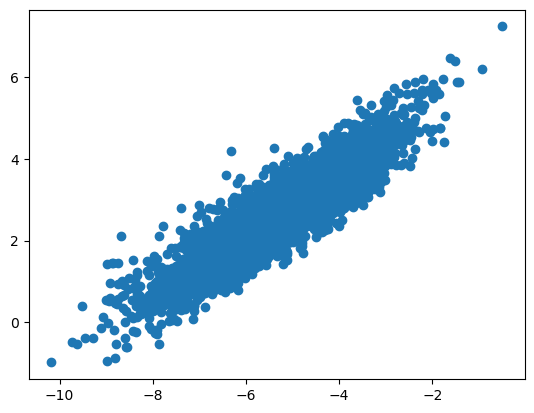

In [10]:
mess_set_FB = mess_set[mess_set['TaggedPitchType'] == 'Fastball']
# Show correlation between pitch height and VAA before normalization
plt.scatter(mess_set_FB['VertApprAngle'], mess_set_FB['PlateLocHeight'])

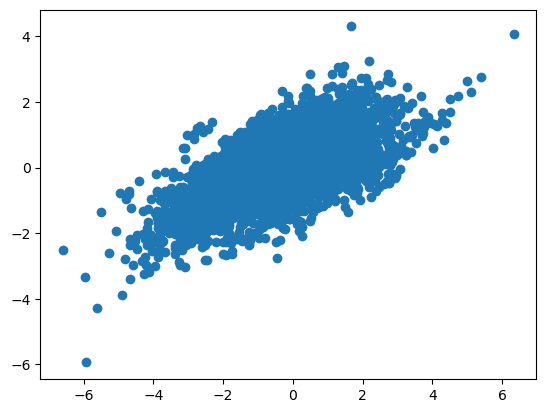

In [12]:
plt.scatter(mess_set_FB['HorzApprAngle'], mess_set_FB['PlateLocSide'])

In [22]:
# Calculate adjusted VAA and adjusted HAA
mess_set_adj = []
vaa_by_height_show = ''
for p_type in mess_set['TaggedPitchType'].unique():
    mess_set_pitch = mess_set[mess_set['TaggedPitchType'] == p_type]
    both_hands = []
    #haa_by_side_hands = []
    # Adjusted HAA - normalize for pitch location and pitcher handedness
    for hand in ['Left', 'Right']:
        mess_set_pitch_hand = mess_set_pitch[mess_set_pitch['PitcherThrows'] == hand]
        mess_set_pitch_hand['side_bin'] = pd.cut(mess_set_pitch_hand['PlateLocSide'], bins=15)

        # Calculate mean HAA for each side bin
        haa_by_side = mess_set_pitch_hand.groupby('side_bin')['HorzApprAngle'].mean().reset_index()

        # Merge this back with the original dataframe
        mess_set_pitch_hand = mess_set_pitch_hand.merge(haa_by_side, on='side_bin', suffixes=('', '_mean'))

        # Calculate HAA Above/Below Average
        mess_set_pitch_hand['AdjustedHAA'] = mess_set_pitch_hand['HorzApprAngle'] - mess_set_pitch_hand['HorzApprAngle_mean']
        
        both_hands.append(mess_set_pitch_hand)
        
    mess_set_pitch = pd.concat(both_hands)
    mess_set_pitch['height_bin'] = pd.cut(mess_set_pitch['PlateLocHeight'], bins=15)

    # Calculate mean VAA for each height bin
    vaa_by_height = mess_set_pitch.groupby('height_bin')['VertApprAngle'].mean().reset_index()
    vaa_by_height_show = vaa_by_height

    # Merge this back with the original dataframe
    mess_set_pitch = mess_set_pitch.merge(vaa_by_height, on='height_bin', suffixes=('', '_mean'))

    # Calculate VAA Above/Below Average
    mess_set_pitch['AdjustedVAA'] = mess_set_pitch['VertApprAngle'] - mess_set_pitch['VertApprAngle_mean']
    
    # Will drop PlateLocSide and PlateLocHeight when applied to all_pitches dataframe
    mess_set_new = mess_set_pitch.drop(columns = ['VertApprAngle', 'HorzApprAngle', 'height_bin', 'side_bin', 'VertApprAngle_mean', 'HorzApprAngle_mean'])
    mess_set_adj.append(mess_set_new)

pd.concat(mess_set_adj)

C:\Users\mdalq\AppData\Local\Temp\ipykernel_27260\602586455.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mess_set_pitch_hand['side_bin'] = pd.cut(mess_set_pitch_hand['PlateLocSide'], bins=15)
C:\Users\mdalq\AppData\Local\Temp\ipykernel_27260\602586455.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  haa_by_side = mess_set_pitch_hand.groupby('side_bin')['HorzApprAngle'].mean().reset_index()
C:\Users\mdalq\AppData\Local\Temp\ipykernel_27260\602586455.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


index        Date             Pitcher PitcherTeam PitcherThrows  \
0      333  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
1      335  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
2      337  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
3      338  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
4      340  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
..     ...         ...                 ...         ...           ...   
297  10982  2024-02-16         Troye, Ryan     SAN_GAU         Right   
298  10985  2024-02-16         Troye, Ryan     SAN_GAU         Right   
299  10986  2024-02-16         Troye, Ryan     SAN_GAU         Right   
300  10987  2024-02-16         Troye, Ryan     SAN_GAU         Right   
301  10988  2024-02-16         Troye, Ryan     SAN_GAU         Right   

    TaggedPitchType       PitchCall      PlayResult  RelSpeed  PlateLocHeight  \
0          Fastball    StrikeCalled       Undefined  89.56139         2.50382   
1          Fastball        FoulBall       Undefined  91.17097         3.87965   
2          Fastball    StrikeCalled       Undefined  88.73077         2.80538   
3          Fastball          InPlay  FieldersChoice  88.38328         2.80027   
4          Fastball      BallCalled       Undefined  88.69125         2.59821   
..              ...             ...             ...       ...             ...   
297          Sinker      BallCalled       Undefined  89.91086         0.84009   
298          Sinker      BallCalled       Undefined  90.18384         1.08090   
299          Sinker      BallCalled       Undefined  89.20440         1.22064   
300          Sinker  StrikeSwinging       Undefined  89.90172         1.67328   
301          Sinker  StrikeSwinging       Undefined  90.80842         1.30663   

     PlateLocSide  RelHeight  RelSide  Extension  InducedVertBreak  HorzBreak  \
0         0.41609    5.99563 -2.62557    5.92561          15.26347  -14.75560   
1        -0.48013    6.12401 -2.53239    5.56583          21.60442  -13.08434   
2         0.02230    5.77085 -3.17374    6.21944           8.58748  -16.77414   
3        -0.92161    5.78454 -3.27641    6.13697           7.92347  -16.73552   
4        -1.92086    5.76804 -3.27874    6.05549           8.08426  -14.43005   
..            ...        ...      ...        ...               ...        ...   
297       2.09219    5.30938  1.75919    6.09677           5.79595   20.51088   
298      -0.33022    5.38318  1.63341    6.37146           6.77134   21.05226   
299       1.42163    5.38253  1.72488    6.64058           3.77788   19.52048   
300       0.41159    5.51333  1.53143    6.51518           7.31339   20.04013   
301       0.69994    5.41010  1.51992    6.47165           7.33426   19.79643   

     AdjustedHAA  AdjustedVAA  
0       0.771710    -0.352832  
1       0.772948     0.408715  
2       0.767888    -0.454553  
3       0.781266    -0.553366  
4       1.322986    -0.666303  
..           ...          ...  
297     0.282832     0.291378  
298     0.561890     0.423809  
299     0.475243     0.240716  
300     0.626373    -0.286872  
301     0.692416    -0.105305  

[10000 rows x 18 columns]

In [24]:
vaa_by_height_show

height_bin  VertApprAngle
0   (-0.659, -0.272]      -9.631316
1    (-0.272, 0.109]      -8.866387
2      (0.109, 0.49]      -8.920369
3      (0.49, 0.872]      -7.879004
4     (0.872, 1.253]      -7.732457
5     (1.253, 1.634]      -6.901900
6     (1.634, 2.016]      -6.495176
7     (2.016, 2.397]      -6.196987
8     (2.397, 2.778]      -5.612368
9      (2.778, 3.16]      -5.072128
10     (3.16, 3.541]      -4.864440
11    (3.541, 3.922]      -4.600820
12    (3.922, 4.304]      -3.906924
13    (4.304, 4.685]      -3.796875
14    (4.685, 5.066]      -2.728360

Now to visualize the results. Both charts below show no correlation between the adjusted VAA and adjusted HAA and the vertical and horizonal location of the pitch, respectively. This metric can now be used as a feature in the Stuff+ model that captures the location-independent affect of approach angles. 

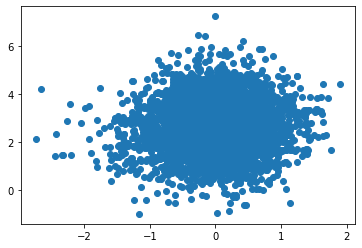

In [288]:
viz_adj = mess_set_adj[mess_set_adj['TaggedPitchType'] == 'Fastball']
plt.scatter(viz_adj['AdjustedVAA'], viz_adj['PlateLocHeight'])

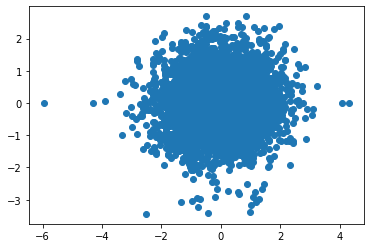

In [289]:
viz_adj = mess_set_adj[mess_set_adj['TaggedPitchType'] == 'Fastball']
plt.scatter(viz_adj['PlateLocSide'], viz_adj['AdjustedHAA'])

Next, I want to look at whether there is any correlation between the new Adjusted VAA and Adjusted HAA metrics and the release point of the pitch.

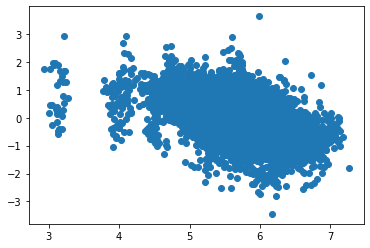

In [290]:
plt.scatter(mess_set_adj['RelHeight'], mess_set_adj['AdjustedVAA'])

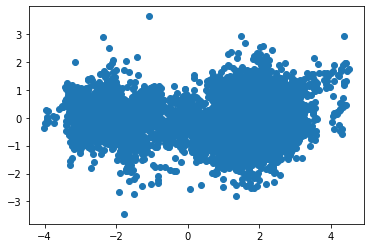

In [291]:
plt.scatter(mess_set_adj['RelSide'], mess_set_adj['AdjustedVAA'])

The first chart, showing the relationship between release height and adjusted VAA shows some negative correlation between the two, but not a lot. All it shows is that once release height exceeds 6ft, it becomes difficult to achieve a flat VAA, but there is enough variation among release heights under 6ft to make it worth keeping it in my model. The second chart, showing the relationship between release side and adjusted HAA shows no correlation between the two. As a result, I will keep both release point metrics in my model as features.

The next step in feature engineering is calculating the difference in movement profiles between each pitcher's primary fastball and their offspeeds. I believe this is a truer reflection of how nasty an offspeed pitch is over its raw movement profile because hitters can and will adjust to the shape of a pitcher's fastball, so differing movement from the fastball will cause whiffs. For instance, two pitchers throw a changeup with 7 IVB and 19 HB, but one has a fastball with 21 IVB and 8 HB while the other has a sinker with 8 IVB and 18 HB, the changeup should not be graded the same. The second pitcher's changeup is nearly identical to his primary fastball, while the first pitcher generates a huge movement difference. Furthermore, the difference in break should help the model more accurately find the characteristics that cause whiffs. I will also account for a difference in velocity when evaluating breaking balls and offspeeds. Some pitchers effectively rely on velocity differences rather than movement differences when throwing these pitches, so I want to capture it in the model.

In [292]:
# Standardize HB to be the same sign for LHP and RHP
mess_set_adj['StandardizedHB'] = mess_set_adj.apply(lambda row: -row['HorzBreak'] if row['PitcherThrows'] == 'Left' else row['HorzBreak'], axis=1)
mess_set_adj

index        Date             Pitcher PitcherTeam PitcherThrows  \
0      333  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
1      337  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
2      351  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
3      354  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
4      458  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
..     ...         ...                 ...         ...           ...   
297  10935  2024-02-16       Freeman, Kamu     CAM_CAM         Right   
298   3391  2024-02-16       Yeager, Isaac     WAS_HUS         Right   
299   5712  2024-02-16        Ray, William     WAK_DEA         Right   
300   3115  2024-02-16            Hood, CJ     LON_DIR         Right   
301   2587  2024-02-16   Cheeseman, Jeremy     FDU_KNI         Right   

    TaggedPitchType       PitchCall PlayResult  RelSpeed  PlateLocHeight  \
0          Fastball    StrikeCalled  Undefined  89.56139         2.50382   
1          Fastball    StrikeCalled  Undefined  88.73077         2.80538   
2          Fastball        FoulBall  Undefined  89.71028         2.55383   
3          Fastball          InPlay        Out  90.05652         2.61858   
4          Fastball  StrikeSwinging  Undefined  89.69116         2.55130   
..              ...             ...        ...       ...             ...   
297          Sinker      BallCalled  Undefined  85.31311         4.65344   
298          Sinker      BallCalled  Undefined  90.85933         4.59836   
299          Sinker      BallCalled  Undefined  89.52002         4.33128   
300          Sinker      BallCalled  Undefined  91.99615         4.92723   
301          Sinker      BallCalled  Undefined  88.27265         5.06630   

     PlateLocSide  RelHeight  RelSide  Extension  InducedVertBreak  HorzBreak  \
0         0.41609    5.99563 -2.62557    5.92561          15.26347  -14.75560   
1         0.02230    5.77085 -3.17374    6.21944           8.58748  -16.77414   
2         0.39137    5.95561 -2.99964    6.17858          16.01985  -14.87418   
3         0.26261    5.95849 -3.04142    6.10764          15.32946  -11.85524   
4        -0.01259    5.96190 -3.11298    6.06580          21.10340  -11.99764   
..            ...        ...      ...        ...               ...        ...   
297      -0.23534    6.23593  1.30265    6.01529          11.04753   10.81819   
298       1.01781    6.03487  1.67413    6.19560          12.41178   18.87021   
299       1.47991    4.58005  2.69431    6.17204           4.06811   22.31356   
300       2.31247    5.97962  1.96347    5.35964          15.04564   16.87091   
301       1.69015    5.07237  1.74307    5.59027          10.88591   18.38001   

     AdjustedHAA  AdjustedVAA  StandardizedHB  
0       0.771710    -0.352832        14.75560  
1       0.767888    -0.454553        16.77414  
2       1.148881    -0.211942        14.87418  
3       1.321952    -0.248385        11.85524  
4       1.088306     0.218124        11.99764  
..           ...          ...             ...  
297     0.100251    -0.604838        10.81819  
298     0.777054     0.065420        18.87021  
299    -0.283225     0.539417        22.31356  
300    -0.060266    -0.246269        16.87091  
301     0.334076     0.246268        18.38001  

[10000 rows x 19 columns]

In [293]:
# Find the fastball each pitcher threw the most frequently (FF, FS, FC)
gb_pitcher = mess_set_adj[(mess_set_adj['TaggedPitchType'] == 'Fastball') | (mess_set_adj['TaggedPitchType'] == 'Sinker') | (mess_set_adj['TaggedPitchType'] == 'Cutter')].groupby(['Pitcher', 'TaggedPitchType']).count()
pitcher_primary_FB = gb_pitcher.groupby(level = 'Pitcher')['Date'].idxmax().apply(lambda x: x[1])
pitcher_primary_FB

Pitcher
Ager, Matt           Fastball
Aiello, Christian    Fastball
Allen, Colby         Fastball
Alloway, Gavin       Fastball
Amborn, Cal          Fastball
                       ...   
Yawn, Garrett        Fastball
Yeager, Isaac          Sinker
Yesavage, Trey       Fastball
Yetter, Brian        Fastball
Young, Brian         Fastball
Name: Date, Length: 247, dtype: object

In [294]:
# Calculate average shape of pitcher's primary fastball
mess_set_adj['primaryFB'] = mess_set_adj['Pitcher'].map(pitcher_primary_FB)
pitcher_FB_shape = mess_set_adj[mess_set_adj['TaggedPitchType'] == mess_set_adj['primaryFB']].groupby('Pitcher')[['RelSpeed','InducedVertBreak', 'StandardizedHB']].mean()
mess_set_adj_shapes = mess_set_adj.merge(pitcher_FB_shape, on='Pitcher', suffixes=('', 'FBavg'))
mess_set_adj_shapes

index        Date               Pitcher PitcherTeam PitcherThrows  \
0       333  2024-02-16    Van Sickle, Bryson     UTA_UTE          Left   
1       337  2024-02-16    Van Sickle, Bryson     UTA_UTE          Left   
2       351  2024-02-16    Van Sickle, Bryson     UTA_UTE          Left   
3       354  2024-02-16    Van Sickle, Bryson     UTA_UTE          Left   
4       458  2024-02-16    Van Sickle, Bryson     UTA_UTE          Left   
...     ...         ...                   ...         ...           ...   
9995   2533  2024-02-16  Kleinfelter, Matthew     JMU_DUK         Right   
9996   2529  2024-02-16  Kleinfelter, Matthew     JMU_DUK         Right   
9997   2530  2024-02-16  Kleinfelter, Matthew     JMU_DUK         Right   
9998   2532  2024-02-16  Kleinfelter, Matthew     JMU_DUK         Right   
9999   2537  2024-02-16  Kleinfelter, Matthew     JMU_DUK         Right   

     TaggedPitchType       PitchCall  PlayResult  RelSpeed  PlateLocHeight  \
0           Fastball    StrikeCalled   Undefined  89.56139         2.50382   
1           Fastball    StrikeCalled   Undefined  88.73077         2.80538   
2           Fastball        FoulBall   Undefined  89.71028         2.55383   
3           Fastball          InPlay         Out  90.05652         2.61858   
4           Fastball  StrikeSwinging   Undefined  89.69116         2.55130   
...              ...             ...         ...       ...             ...   
9995          Cutter    StrikeCalled   Undefined  81.73820         1.53740   
9996          Cutter      BallCalled   Undefined  83.00333         3.26504   
9997          Cutter    StrikeCalled   Undefined  84.02201         3.10190   
9998          Cutter      BallCalled   Undefined  81.30962         1.28216   
9999          Cutter      BallCalled  StolenBase  80.65536        -0.61309   

      ...  Extension  InducedVertBreak  HorzBreak  AdjustedHAA  AdjustedVAA  \
0     ...    5.92561          15.26347  -14.75560     0.771710    -0.352832   
1     ...    6.21944           8.58748  -16.77414     0.767888    -0.454553   
2     ...    6.17858          16.01985  -14.87418     1.148881    -0.211942   
3     ...    6.10764          15.32946  -11.85524     1.321952    -0.248385   
4     ...    6.06580          21.10340  -11.99764     1.088306     0.218124   
...   ...        ...               ...        ...          ...          ...   
9995  ...    5.26035           9.36788    0.13472    -2.471004     1.530497   
9996  ...    5.53231           7.17461    0.29909    -2.199729     1.305488   
9997  ...    5.27573           6.59729   -3.14571    -1.725226    -0.256852   
9998  ...    5.40685           6.64804   -0.41508    -1.606043     1.072817   
9999  ...    5.41088           6.17910   -0.61925    -1.731802     1.602581   

      StandardizedHB  primaryFB  RelSpeedFBavg  InducedVertBreakFBavg  \
0           14.75560   Fastball      89.232838              12.707468   
1           16.77414   Fastball      89.232838              12.707468   
2           14.87418   Fastball      89.232838              12.707468   
3           11.85524   Fastball      89.232838              12.707468   
4           11.99764   Fastball      89.232838              12.707468   
...              ...        ...            ...                    ...   
9995         0.13472     Cutter      81.906520               7.508612   
9996         0.29909     Cutter      81.906520               7.508612   
9997        -3.14571     Cutter      81.906520               7.508612   
9998        -0.41508     Cutter      81.906520               7.508612   
9999        -0.61925     Cutter      81.906520               7.508612   

     StandardizedHBFBavg  
0              15.241801  
1              15.241801  
2              15.241801  
3              15.241801  
4              15.241801  
...                  ...  
9995           -0.608899  
9996           -0.608899  
9997           -0.608899  
9998           -0.608899  
9999           -0.608899  

[10000 rows x 23 

In [298]:
# Slice dataframe in two - one for fastballs (all FF, FS, FC will be standalone, not dependent on primary FB shape) - one for 
# offspeed (use avg columns to do array subtraction)
mess_adj_shape_FB = mess_set_adj_shapes[(mess_set_adj_shapes['TaggedPitchType'] == 'Fastball') | (mess_set_adj_shapes['TaggedPitchType'] == 'Sinker') | ((mess_set_adj_shapes['TaggedPitchType'] == 'Cutter') & (mess_set_adj_shapes['primaryFB'] == 'Cutter'))]
mess_adj_shape_BB = mess_set_adj_shapes[(mess_set_adj_shapes['TaggedPitchType'] == 'Curveball') | (mess_set_adj_shapes['TaggedPitchType'] == 'Slider') | ((mess_set_adj_shapes['TaggedPitchType'] == 'Cutter') & (mess_set_adj_shapes['primaryFB'] != 'Cutter'))]
mess_adj_shape_OS = mess_set_adj_shapes[(mess_set_adj_shapes['TaggedPitchType'] == 'ChangeUp') | (mess_set_adj_shapes['TaggedPitchType'] == 'Splitter') | (mess_set_adj_shapes['TaggedPitchType'] == 'Knuckleball')]

mess_adj_shape_BB['VeloDiff'] = mess_adj_shape_BB['RelSpeed'] - mess_adj_shape_BB['RelSpeedFBavg']
mess_adj_shape_BB['IVBDiff'] = mess_adj_shape_BB['InducedVertBreak'] - mess_adj_shape_BB['InducedVertBreakFBavg']
mess_adj_shape_BB['HBDiff'] = mess_adj_shape_BB['StandardizedHB'] - mess_adj_shape_BB['StandardizedHBFBavg']

mess_adj_shape_OS['VeloDiff'] = mess_adj_shape_OS['RelSpeed'] - mess_adj_shape_OS['RelSpeedFBavg']
mess_adj_shape_OS['IVBDiff'] = mess_adj_shape_OS['InducedVertBreak'] - mess_adj_shape_OS['InducedVertBreakFBavg']
mess_adj_shape_OS['HBDiff'] = mess_adj_shape_OS['StandardizedHB'] - mess_adj_shape_OS['StandardizedHBFBavg']

mess_adj_shape_BB

C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\2976215820.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mess_adj_shape_BB['VeloDiff'] = mess_adj_shape_BB['RelSpeed'] - mess_adj_shape_BB['RelSpeedFBavg']
C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\2976215820.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mess_adj_shape_BB['IVBDiff'] = mess_adj_shape_BB['InducedVertBreak'] - mess_adj_shape_BB['InducedVertBreakFBavg']
C:\Users\Matthew Dalquist\AppData\Local\Temp\ipyker

index        Date             Pitcher PitcherTeam PitcherThrows  \
55      405  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
56      334  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
57      342  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
58      440  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
59      336  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
...     ...         ...                 ...         ...           ...   
9967   5707  2024-02-16        Ray, William     WAK_DEA         Right   
9968   5717  2024-02-16        Ray, William     WAK_DEA         Right   
9979  10983  2024-02-16         Troye, Ryan     SAN_GAU         Right   
9980  10980  2024-02-16         Troye, Ryan     SAN_GAU         Right   
9981  10984  2024-02-16         Troye, Ryan     SAN_GAU         Right   

     TaggedPitchType     PitchCall PlayResult  RelSpeed  PlateLocHeight  ...  \
55         Curveball    BallCalled  Undefined  76.20326         0.75848  ...   
56            Slider      FoulBall  Undefined  77.33869         2.49283  ...   
57            Slider      FoulBall  Undefined  75.62675         2.94672  ...   
58            Slider      FoulBall  Undefined  76.64753         2.39937  ...   
59            Slider        InPlay     Single  77.75408         1.91605  ...   
...              ...           ...        ...       ...             ...  ...   
9967          Slider        InPlay        Out  79.58015         1.57233  ...   
9968          Slider        InPlay     Double  80.01195         1.39424  ...   
9979          Slider  StrikeCalled  Undefined  82.66973         2.49908  ...   
9980          Slider    BallCalled  Undefined  81.62017         1.77058  ...   
9981          Slider    BallCalled  Undefined  82.63837         1.57779  ...   

      AdjustedHAA  AdjustedVAA  StandardizedHB  primaryFB  RelSpeedFBavg  \
55       0.212550     0.046978        -4.31610   Fastball      89.232838   
56       0.926026    -1.127232        -7.09296   Fastball      89.232838   
57       1.192919    -0.726199        -8.80158   Fastball      89.232838   
58       0.973813    -1.284005       -11.75705   Fastball      89.232838   
59       0.648719    -1.033744        -7.85355   Fastball      89.232838   
...           ...          ...             ...        ...            ...   
9967    -1.278562     1.112209       -12.34969     Sinker      89.084985   
9968    -1.015990     0.949030       -10.39642     Sinker      89.084985   
9979     0.612564     0.620603        -2.05453     Sinker      89.952319   
9980     1.015865     0.259101        -3.01425     Sinker      89.952319   
9981     0.805000     0.839565        -4.06642     Sinker      89.952319   

      InducedVertBreakFBavg  StandardizedHBFBavg   VeloDiff    IVBDiff  \
55                12.707468            15.241801 -13.029578 -20.264558   
56                12.707468            15.241801 -11.894148 -18.406248   
57                12.707468            15.241801 -13.606088 -15.804518   
58                12.707468            15.241801 -12.585308 -17.381208   
59                12.707468            15.241801 -11.478758 -16.828648   
...                     ...                  ...        ...        ...   
9967               3.073242            20.694207  -9.504835  -6.317652   
9968               3.073242            20.694207  -9.073035  -5.002772   
9979               5.603991            20.149387  -7.282589  -0.901191   
9980               5.603991            20.149387  -8.332149  -5.099541   
9981               5.603991            20.149387  -7.313949  -4.396511   

         HBDiff  
55   -19.557901  
56   -22.334761  
57   -24.043381  
58   -26.998851  
59   -23.095351  
...         ...  
9967 -33.043897  
9968 -31.090627  
9979 -22.203917  
9980 -23.163638  
9981 -24.215808  

[3033 rows x 26 columns]

In [7]:
# apply changes from mess set to full data
def calc_adj_vaa_haa(pitches):
    pitches_adj = []
    for p_type in pitches['TaggedPitchType'].unique():
        pitches_pitch = pitches[pitches['TaggedPitchType'] == p_type]
        both_hands = []
        # Adjusted HAA - normalize for pitch location and pitcher handedness
        for hand in ['Left', 'Right']:
            pitches_pitch_hand = pitches_pitch[pitches_pitch['PitcherThrows'] == hand]
            pitches_pitch_hand['side_bin'] = pd.cut(pitches_pitch_hand['PlateLocSide'], bins=15)

            # Calculate mean HAA for each side bin
            haa_by_side = pitches_pitch_hand.groupby('side_bin')['HorzApprAngle'].mean().reset_index()
            haa_by_side.to_csv(f"haa_by_side_{p_type}_{hand}")

            # Merge this back with the original dataframe
            pitches_pitch_hand = pitches_pitch_hand.merge(haa_by_side, on='side_bin', suffixes=('', '_mean'))

            # Calculate HAA Above/Below Average
            pitches_pitch_hand['AdjustedHAA'] = pitches_pitch_hand['HorzApprAngle'] - pitches_pitch_hand['HorzApprAngle_mean']

            both_hands.append(pitches_pitch_hand)

        pitches_pitch = pd.concat(both_hands)
        pitches_pitch['height_bin'] = pd.cut(pitches_pitch['PlateLocHeight'], bins=15)

        # Calculate mean VAA for each height bin
        vaa_by_height = pitches_pitch.groupby('height_bin')['VertApprAngle'].mean().reset_index()
        vaa_by_height.to_csv(f"vaa_by_height_{p_type}.csv")

        # Merge this back with the original dataframe
        pitches_pitch = pitches_pitch.merge(vaa_by_height, on='height_bin', suffixes=('', '_mean'))

        # Calculate VAA Above/Below Average
        pitches_pitch['AdjustedVAA'] = pitches_pitch['VertApprAngle'] - pitches_pitch['VertApprAngle_mean']

        # Will drop PlateLocSide and PlateLocHeight when applied to all_pitches dataframe
        pitches_new = pitches_pitch.drop(columns = ['VertApprAngle', 'HorzApprAngle', 'PlateLocHeight', 'PlateLocSide', 'height_bin', 'side_bin', 'VertApprAngle_mean', 'HorzApprAngle_mean'])
        pitches_adj.append(pitches_new)
    return pd.concat(pitches_adj)
    
all_pitches = calc_adj_vaa_haa(all_pitches)

all_pitches['StandardizedHB'] = all_pitches.apply(lambda row: -row['HorzBreak'] if row['PitcherThrows'] == 'Left' else row['HorzBreak'], axis=1)

def get_pitcher_primary_FB_info(pitches):
    gb_pitcher = pitches[(pitches['TaggedPitchType'] == 'Fastball') | (pitches['TaggedPitchType'] == 'Sinker') | (pitches['TaggedPitchType'] == 'Cutter')].groupby(['Pitcher', 'TaggedPitchType']).count()
    pitcher_primary_FB = gb_pitcher.groupby(level = 'Pitcher')['Date'].idxmax().apply(lambda x: x[1])
    pitches['primaryFB'] = pitches['Pitcher'].map(pitcher_primary_FB)
    pitcher_FB_shape = pitches[pitches['TaggedPitchType'] == pitches['primaryFB']].groupby('Pitcher')[['RelSpeed','InducedVertBreak', 'StandardizedHB']].mean()
    pitches_shapes = pitches.merge(pitcher_FB_shape, on='Pitcher', suffixes=('', 'FBavg'))
    return pitches_shapes

all_pitches = get_pitcher_primary_FB_info(all_pitches)

all_pitches_FB = all_pitches[(all_pitches['TaggedPitchType'] == 'Fastball') | (all_pitches['TaggedPitchType'] == 'Sinker') | (all_pitches['TaggedPitchType'] == 'Cutter')]
all_pitches_BB = all_pitches[(all_pitches['TaggedPitchType'] == 'Curveball') | (all_pitches['TaggedPitchType'] == 'Slider')]
all_pitches_OS = all_pitches[(all_pitches['TaggedPitchType'] == 'ChangeUp') | (all_pitches['TaggedPitchType'] == 'Splitter') | (all_pitches['TaggedPitchType'] == 'Knuckleball')]

all_pitches_BB['VeloDiff'] = all_pitches_BB['RelSpeed'] - all_pitches_BB['RelSpeedFBavg']
all_pitches_BB['IVBDiff'] = all_pitches_BB['InducedVertBreak'] - all_pitches_BB['InducedVertBreakFBavg']
all_pitches_BB['HBDiff'] = all_pitches_BB['StandardizedHB'] - all_pitches_BB['StandardizedHBFBavg']

all_pitches_OS['VeloDiff'] = all_pitches_OS['RelSpeed'] - all_pitches_OS['RelSpeedFBavg']
all_pitches_OS['IVBDiff'] = all_pitches_OS['InducedVertBreak'] - all_pitches_OS['InducedVertBreakFBavg']
all_pitches_OS['HBDiff'] = all_pitches_OS['StandardizedHB'] - all_pitches_OS['StandardizedHBFBavg']

all_pitches

C:\Users\mdalq\AppData\Local\Temp\ipykernel_23616\1371744206.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitches_pitch_hand['side_bin'] = pd.cut(pitches_pitch_hand['PlateLocSide'], bins=15)
C:\Users\mdalq\AppData\Local\Temp\ipykernel_23616\1371744206.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  haa_by_side = pitches_pitch_hand.groupby('side_bin')['HorzApprAngle'].mean().reset_index()
C:\Users\mdalq\AppData\Local\Temp\ipykernel_23616\1371744206.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


index        Date             Pitcher PitcherTeam PitcherThrows  \
0            333  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
1            335  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
2            337  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
3            338  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
4            340  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
...          ...         ...                 ...         ...           ...   
1436403  1534999  2024-05-14       Schuelke, Cam     MSU_BDG         Right   
1436404  1585901  2024-05-17        Durgin, Nick     STE_HAT         Right   
1436405  1591387  2024-05-17     Lohman, Griffin     PUR_BOI         Right   
1436406  1683549  2024-06-02        Ward, Nathan     GRA_CAN         Right   
1436407  1685329  2024-06-02      Bovair, Connor     NOR_TAR         Right   

        TaggedPitchType             PitchCall      PlayResult  RelSpeed  \
0              Fastball          StrikeCalled       Undefined  89.56139   
1              Fastball              FoulBall       Undefined  91.17097   
2              Fastball          StrikeCalled       Undefined  88.73077   
3              Fastball                InPlay  FieldersChoice  88.38328   
4              Fastball            BallCalled       Undefined  88.69125   
...                 ...                   ...             ...       ...   
1436403     Knuckleball          StrikeCalled       Undefined  68.85133   
1436404     Knuckleball  FoulBallNotFieldable       Undefined  82.93742   
1436405     Knuckleball            BallCalled       Undefined  82.82098   
1436406     Knuckleball            BallCalled       Undefined  77.29063   
1436407     Knuckleball  FoulBallNotFieldable       Undefined  90.83780   

         RelHeight  ...  Extension  InducedVertBreak  HorzBreak  AdjustedHAA  \
0          5.99563  ...    5.92561          15.26347  -14.75560     0.418580   
1          6.12401  ...    5.56583          21.60442  -13.08434     0.275133   
2          5.77085  ...    6.21944           8.58748  -16.77414     1.194025   
3          5.78454  ...    6.13697           7.92347  -16.73552     1.057966   
4          5.76804  ...    6.05549           8.08426  -14.43005     0.946016   
...            ...  ...        ...               ...        ...          ...   
1436403    2.23701  ...    4.46941          11.81505  -18.55446    -2.186277   
1436404    6.31967  ...    5.56973           3.07811   -4.59516     0.330219   
1436405    6.18933  ...    4.53251          -2.48819    2.28252     0.224672   
1436406    5.46396  ...    5.44188          -1.98441   -7.61382     0.041203   
1436407    5.71434  ...    5.35475          17.25938   13.80300     1.525789   

         AdjustedVAA  StandardizedHB  primaryFB RelSpeedFBavg  \
0          -0.482110        14.75560     Sinker     88.436251   
1           0.549336        13.08434     Sinker     88.436251   
2          -0.583831        16.77414     Sinker     88.436251   
3          -0.682644        16.73552     Sinker     88.436251   
4          -0.795581        14.43005     Sinker     88.436251   
...              ...             ...        ...           ...   
1436403     2.238172       -18.55446     Sinker     85.164848   
1436404    -1.699487        -4.59516   Fastball     89.528954   
1436405    -1.484021         2.28252   Fastball     88.761039   
1436406    -0.872908        -7.61382   Fastball     87.948690   
1436407     1.108367        13.80300   Fastball     90.709771   

         InducedVertBreakFBavg  StandardizedHBFBavg  
0                    10.740111            14.436070  
1                    10.740111            14.436070  
2                    10.740111            14.436070  
3                    10.740111            14.436070  
4                    10.740111            14.436070  
...                        ...                  ...  
1436403              -6.931951            15.509286  

The features I will use for my model are: RelSpeed, RelHeight, RelSide, Extension, InducedVertBreak, HorzBreak, AdjustedVAA, AdjustedHAA, VeloDiff, IVBDiff, HBDiff (last 3 won't be included in the Fastball model, obviously)

In [9]:
all_pitches['AdjustedHAA'].isna().sum()

0

In [16]:
# check all recorded outcomes for labels indicating swings
all_pitches['PitchCall'].value_counts()

PitchCall
BallCalled               538353
StrikeCalled             253135
InPlay                   244590
FoulBallNotFieldable     176402
StrikeSwinging           147289
FoulBall                  45280
BallinDirt                15057
HitByPitch                12397
FoulBallFieldable          3722
BallIntentional             129
Undefined                    51
BattersInterference           1
StrkeSwinging                 1
FouldBallNotFieldable         1
Name: count, dtype: int64

In [113]:
# remove 'Undefined' pitches from dataset
all_pitches = all_pitches[(all_pitches['PitchCall'] != 'Undefined') & (all_pitches['PitchCall'] != 'BattersInterference')]
all_pitches.shape[0]

1436356

# Initial Model: Logistic Regression

Logistic Regression is not the best method to use for this project but it is something I want to try and it makes sense given the data I have and the outcome I desire. I am basing this Stuff+ model off expected whiff rate (xWhiff). I chose this because I see Stuff+ as the metric that describes how "nasty" a pitch is, and I believe the biggest indicator of nastiness is how often hitters swing and miss. In this case, I will use all of the swings as my training data and the takes as validation/test sets. Each swing either resulted in contact (foul, in play) or a whiff (swinging strike). Since the response (dependent) variable is a binary outcome, and the result I want is some sort of whiff rate or whiff score (between 0 and 1) that determines how that pitch is to produce a whiff, logistic regression makes perfect sense. While it will not do well capturing the intricacies of the data, it gives me a good baseline and a starting point to learn more about the data before choosing another ML algorithm.

In [20]:
swings = all_pitches_FB[(all_pitches_FB['PitchCall'] == 'FoulBall') | (all_pitches_FB['PitchCall'] == 'FoulBallNotFieldable') | (all_pitches_FB['PitchCall'] == 'FoulBallFieldable') | (all_pitches_FB['PitchCall'] == 'FouldBallNotFieldable') | (all_pitches_FB['PitchCall'] == 'StrkeSwinging') | (all_pitches_FB['PitchCall'] == 'InPlay') | (all_pitches_FB['PitchCall'] == 'StrikeSwinging')][['PitchCall', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA']].dropna()
swings

PitchCall   RelSpeed  RelHeight  RelSide  Extension  \
1                    FoulBall   91.17097    6.12401 -2.53239    5.56583   
3                      InPlay   88.38328    5.78454 -3.27641    6.13697   
5                      InPlay   88.97922    5.90387 -3.17586    6.08399   
6                    FoulBall   89.34685    5.77796 -3.16381    6.12316   
8                    FoulBall   87.87922    5.82114 -3.29665    6.24615   
...                       ...        ...        ...      ...        ...   
1436188                InPlay  100.73406    5.41998  2.26517    5.26018   
1436191  FoulBallNotFieldable  100.74958    5.44311  2.25273    5.04972   
1436192  FoulBallNotFieldable  101.01324    5.51440  2.19598    5.16213   
1436193        StrikeSwinging   99.39796    5.53011  2.19111    5.08184   
1436197                InPlay  100.27414    5.58900  2.20989    4.85881   

         InducedVertBreak  StandardizedHB  AdjustedVAA  AdjustedHAA  
1                21.60442        13.08434     0.549336     0.275133  
3                 7.92347        16.73552    -0.682644     1.057966  
5                10.91256        16.81469    -0.937262     1.244567  
6                10.32619        17.97525    -0.285712     0.586107  
8                11.47209        16.78615    -0.981060     0.769545  
...                   ...             ...          ...          ...  
1436188           3.32358        19.67115     0.325294     0.189117  
1436191           6.41650        16.36698     0.542126    -0.182789  
1436192           5.04083        21.10753    -0.012845     0.552849  
1436193           5.13862        18.13422     0.203120    -0.163653  
1436197           9.59375        15.79548     0.742214    -0.136901  

[370845 rows x 9 columns]

In [22]:
swings['PitchCall'] = swings['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)
swings

PitchCall   RelSpeed  RelHeight  RelSide  Extension  \
1                0   91.17097    6.12401 -2.53239    5.56583   
3                0   88.38328    5.78454 -3.27641    6.13697   
5                0   88.97922    5.90387 -3.17586    6.08399   
6                0   89.34685    5.77796 -3.16381    6.12316   
8                0   87.87922    5.82114 -3.29665    6.24615   
...            ...        ...        ...      ...        ...   
1436188          0  100.73406    5.41998  2.26517    5.26018   
1436191          0  100.74958    5.44311  2.25273    5.04972   
1436192          0  101.01324    5.51440  2.19598    5.16213   
1436193          1   99.39796    5.53011  2.19111    5.08184   
1436197          0  100.27414    5.58900  2.20989    4.85881   

         InducedVertBreak  StandardizedHB  AdjustedVAA  AdjustedHAA  
1                21.60442        13.08434     0.549336     0.275133  
3                 7.92347        16.73552    -0.682644     1.057966  
5                10.91256        16.81469    -0.937262     1.244567  
6                10.32619        17.97525    -0.285712     0.586107  
8                11.47209        16.78615    -0.981060     0.769545  
...                   ...             ...          ...          ...  
1436188           3.32358        19.67115     0.325294     0.189117  
1436191           6.41650        16.36698     0.542126    -0.182789  
1436192           5.04083        21.10753    -0.012845     0.552849  
1436193           5.13862        18.13422     0.203120    -0.163653  
1436197           9.59375        15.79548     0.742214    -0.136901  

[370845 rows x 9 columns]

In [24]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [26]:
X_train, X_test, y_train, y_test = train_test_split(swings.drop(columns = 'PitchCall'), swings['PitchCall'], test_size=0.1, random_state=42)

log_reg_model_FB = linear_model.LogisticRegression(max_iter = 1000).fit(X_train, y_train)
results_FB = log_reg_model_FB.predict_proba(X_train)

In [28]:
x_whiff = [x[1] for x in results_FB]
x_whiff[:10]

[0.14470646409688132,
 0.16529119206383866,
 0.16766310183504424,
 0.14069937171543329,
 0.14178573389542704,
 0.2531713846583737,
 0.19690752252859173,
 0.15498091245273504,
 0.24763999507836287,
 0.178730522413075]

In [30]:
avg_x_whiff_train = np.mean(x_whiff)
avg_x_whiff_train

0.18456618086506413

In [32]:
actual_whiff_pct_train = y_train.mean()
actual_whiff_pct_train

0.18456675455417065

Model must be doing something right. Lets see if it holds up for test data

In [34]:
results_test_FB = log_reg_model_FB.predict_proba(X_test)
x_whiff_test = [x[1] for x in results_test_FB]
avg_x_whiff_test = np.mean(x_whiff_test)
actual_whiff_pct_test = y_test.mean()
avg_x_whiff_test, actual_whiff_pct_test

(0.1845191718102254, 0.18212215181340163)

Also very close. The model seems to be accurately capturing the frequency of whiffs on fastballs. Now let's use a more robust accuracy metric to determine the strength of the model. I will use Log Loss, or Cross Entropy loss, as it reliably captures loss when the output is a probability and the labels are binary, while taking into account confidence of prediction.

In [36]:
train_log_loss = metrics.log_loss(y_train, x_whiff)
test_log_loss = metrics.log_loss(y_test, x_whiff_test)
train_log_loss, test_log_loss

(0.4719701543288471, 0.4682799746207719)

Compare to baseline of predicting no whiff (~82% of fastballs were not whiffed at) for every pitch

In [39]:
no_skill_baseline_logloss_FB = metrics.log_loss(y_test, np.zeros(y_test.shape[0]))
no_skill_baseline_logloss_FB

6.564347714442422

So yes, the logistic regression model fares better than the trivial model. Now let's visualize the results

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 88-90mph')]

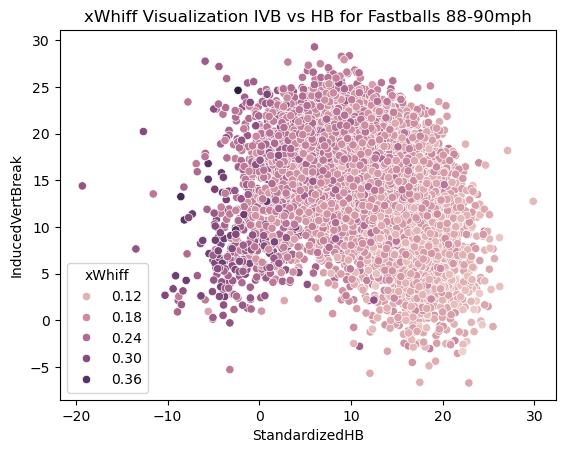

In [41]:
import seaborn as sns

X_test['xWhiff'] = x_whiff_test
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 88-90mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 90-92mph')]

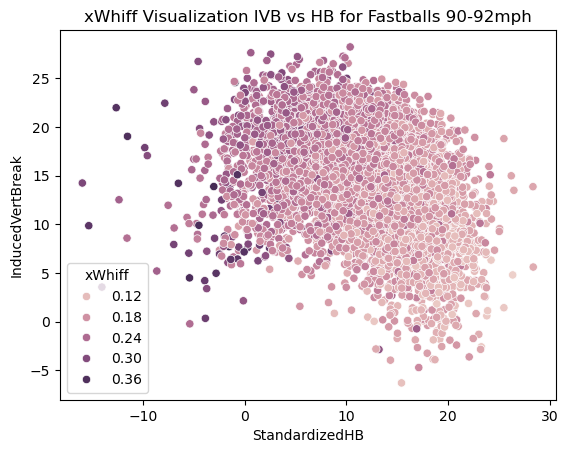

In [42]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 90) & (X_test['RelSpeed'] < 92)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 90) & (X_test['RelSpeed'] < 92)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 90) & (X_test['RelSpeed'] < 92)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 90-92mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 92-95mph')]

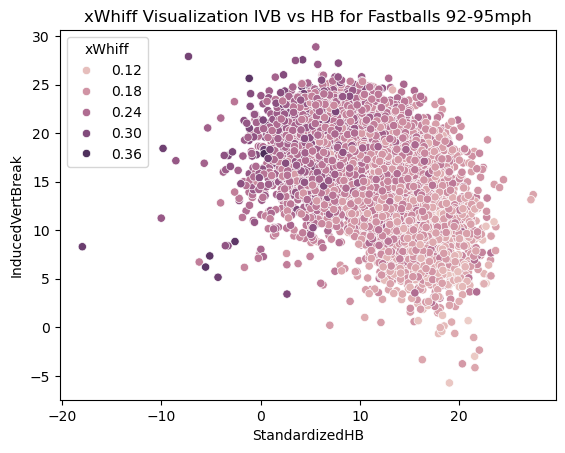

In [45]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 92-95mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs >95mph')]

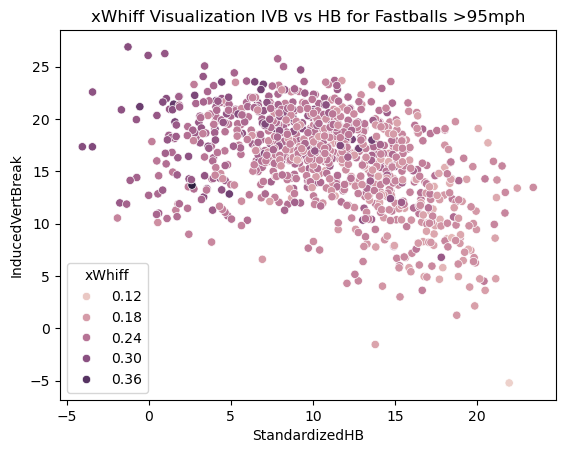

In [46]:
sns.scatterplot(x = X_test[X_test['RelSpeed'] > 95]['StandardizedHB'], y = X_test[X_test['RelSpeed'] > 95]['InducedVertBreak'], hue = X_test[X_test['RelSpeed'] > 95]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs >95mph')

These visualizations don't capture all the features in the model, but they give a good sense of what the model is doing. A few things stand out. First of all, as the velocity increases over the course of the charts, the concentration of darker purple dots, indicating higher xWhiff, increases. This makes sense, as faster fastballs tend to be swung and missed at more and tend to be better pitches. Secondly, the model (as expected) has difficulty capturing finer elements of the data. It favors high IVB fastballs, which also makes sense, but significantly reduces the xWhiff of low very IVB fastballs. Very low IVB fastballs tend to be very good sinkers, which also generate swings and misses. In my first iteration of the model, I used Horizontal Break as a standard feature, which it struggled to capture as a feature. By leaving horizontal break as is, LHP will throw fastballs with negative HB and righties will throw fastballs with positive HB, and naturally so, this does not align with what logistic regression can capture. However, by flipping the sign of LHP HB, the model now seems to favor cutters, with HB close to 0, so perhaps that is the model saying that pitch type is effective.

To generate baselines for the other pitch types, I will create Logistic Regression models for Breaking Balls and Offspeeds just as I did for fastballs

In [49]:
swings = all_pitches_BB[(all_pitches_BB['PitchCall'] == 'FoulBall') | (all_pitches_BB['PitchCall'] == 'FoulBallNotFieldable') | (all_pitches_BB['PitchCall'] == 'FoulBallFieldable') | (all_pitches_BB['PitchCall'] == 'FouldBallNotFieldable') | (all_pitches_BB['PitchCall'] == 'StrkeSwinging') | (all_pitches_BB['PitchCall'] == 'InPlay') | (all_pitches_BB['PitchCall'] == 'StrikeSwinging')][['PitchCall', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA', 'VeloDiff', 'IVBDiff', 'HBDiff']].dropna()
swings['PitchCall'] = swings['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)
swings

PitchCall  RelSpeed  RelHeight  RelSide  Extension  InducedVertBreak  \
863607           0  77.01214    6.32641 -1.68659    5.69175         -13.44532   
863608           1  78.34449    6.24592 -1.51912    5.66769         -14.70434   
863614           0  77.27140    6.05294 -1.78047    5.86374         -11.91044   
863618           0  76.62114    6.29624 -1.67715    5.80499         -10.92934   
863622           0  73.13610    6.32797 -1.63201    5.56573         -13.39320   
...            ...       ...        ...      ...        ...               ...   
1287421          1  90.65707    5.39875  2.02947    5.28638           9.35630   
1287423          1  88.93943    5.33288  1.70100    5.31938           9.40268   
1287424          0  77.36517    4.94622  1.82857    4.53763         -15.80698   
1287425          0  75.90259    4.99481  1.57389    4.74929         -14.53080   
1287426          1  78.95801    4.91003  1.38229    4.84387         -12.73579   

         StandardizedHB  AdjustedVAA  AdjustedHAA   VeloDiff    IVBDiff  \
863607         -4.64500    -0.873305    -0.461140 -11.495353 -34.013056   
863608         -8.40398    -0.492023    -0.169904 -10.163003 -35.272076   
863614         -9.11910    -0.380878    -0.148044 -11.236093 -32.478176   
863618         -4.38488    -0.543835    -0.405715 -11.886353 -31.497076   
863622         -9.01823    -1.572114     0.037258 -15.371393 -33.960936   
...                 ...          ...          ...        ...        ...   
1287421         2.89142     2.429936     0.481227  -5.779804   0.789149   
1287423        -1.47630     1.885441     1.017725  -7.497444   0.835529   
1287424       -20.15666    -1.542554    -1.483856 -14.698265 -32.625315   
1287425       -17.04442    -0.970744    -0.638339 -16.160845 -31.349135   
1287426       -17.86462    -0.881003    -0.543906 -13.105425 -29.554125   

            HBDiff  
863607  -18.439866  
863608  -22.198846  
863614  -22.913966  
863618  -18.179746  
863622  -22.813096  
...            ...  
1287421 -14.302503  
1287423 -18.670223  
1287424 -35.954343  
1287425 -32.842103  
1287426 -33.662303  

[167144 rows x 12 columns]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(swings.drop(columns = 'PitchCall'), swings['PitchCall'], test_size=0.1, random_state=42)

log_reg_model_BB = linear_model.LogisticRegression(max_iter = 1000).fit(X_train, y_train)
results_BB = log_reg_model_BB.predict_proba(X_train)
x_whiff_train_BB = [x[1] for x in results_BB]
avg_x_whiff_train_BB = np.mean(x_whiff_train_BB)
actual_whiff_pct_train_BB = y_train.mean()
avg_x_whiff_train_BB, actual_whiff_pct_train_BB

(0.3204844619335899, 0.32048341742616115)

In [52]:
results_test_BB = log_reg_model_BB.predict_proba(X_test)
x_whiff_test_BB = [x[1] for x in results_test_BB]
avg_x_whiff_test_BB = np.mean(x_whiff_test_BB)
actual_whiff_pct_test_BB = y_test.mean()
avg_x_whiff_test_BB, actual_whiff_pct_test_BB

(0.320607773255669, 0.31672150762787915)

In [53]:
train_log_loss_BB = metrics.log_loss(y_train, x_whiff_train_BB)
test_log_loss_BB = metrics.log_loss(y_test, x_whiff_test_BB)
train_log_loss_BB, test_log_loss_BB

(0.620562221741451, 0.6176603392479465)

In [54]:
no_skill_baseline_logloss_BB = metrics.log_loss(y_test, np.zeros(y_test.shape[0]))
no_skill_baseline_logloss_BB

11.415800241817902

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls <70mph')]

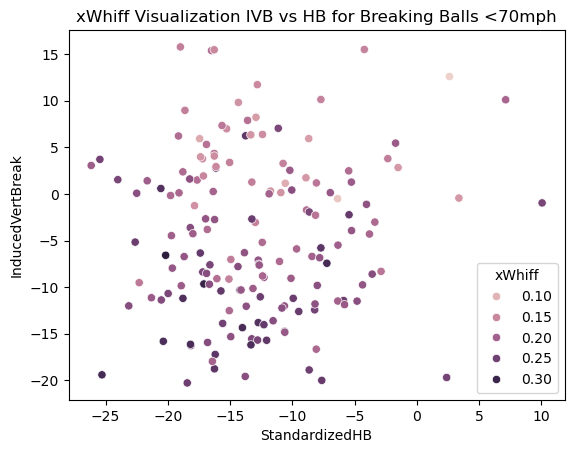

In [59]:
X_test['xWhiff'] = x_whiff_test_BB
sns.scatterplot(x = X_test[(X_test['RelSpeed'] < 70)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] < 70)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] < 70)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls <70mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls 70-75mph')]

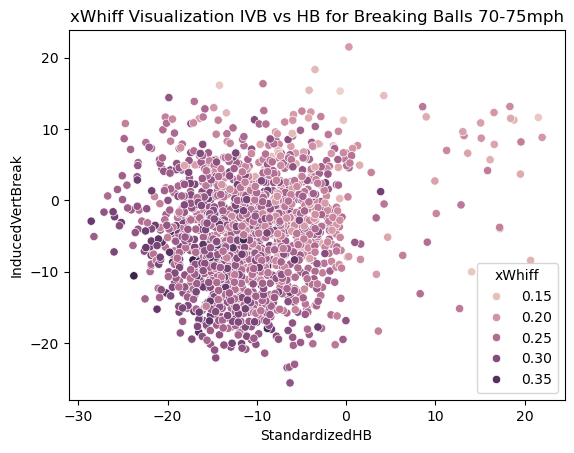

In [61]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 70) & (X_test['RelSpeed'] < 75)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 70) & (X_test['RelSpeed'] < 75)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 70) & (X_test['RelSpeed'] < 75)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls 70-75mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls 75-80mph')]

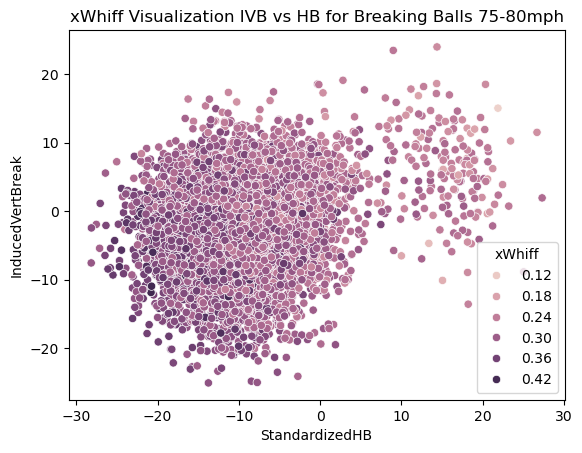

In [63]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 75) & (X_test['RelSpeed'] < 80)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 75) & (X_test['RelSpeed'] < 80)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 75) & (X_test['RelSpeed'] < 80)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls 75-80mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls 80-85mph')]

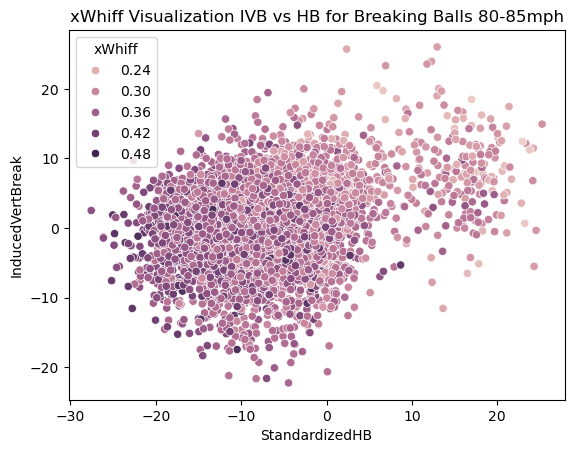

In [64]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 85)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 85)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 85)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls 80-85mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls >85mph')]

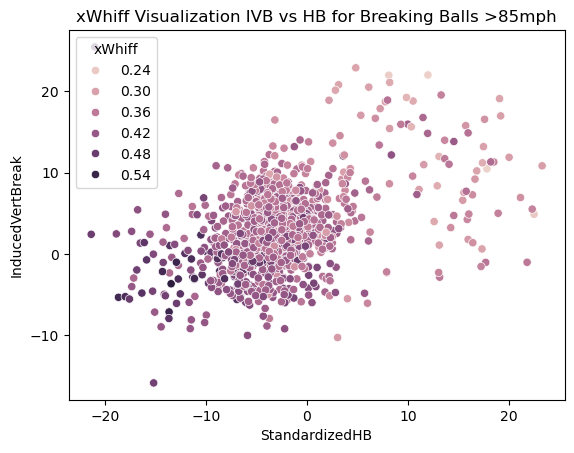

In [66]:
sns.scatterplot(x = X_test[X_test['RelSpeed'] > 85]['StandardizedHB'], y = X_test[X_test['RelSpeed'] > 85]['InducedVertBreak'], hue = X_test[X_test['RelSpeed'] > 85]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls >85mph')

As with the Fastball model, the Breaking Ball model favors harder breaking balls. The maximum xWhiff on the <70 mph legend is 0.3, right around the average for the dataset, while the maximum xWhiff for the  85+ legend is 0.54. Similarly, the model favors negative IVB and more glove side HB, although it seems more random in the 75-85mph range. Perhaps other features are at play here. All in all, the model favors hard breaking balls with lots of depth, which for a baseball sense, makes a lot of sense, but there is still some intricacy this model has yet to capture.

In [70]:
swings = all_pitches_OS[(all_pitches_OS['PitchCall'] == 'FoulBall') | (all_pitches_OS['PitchCall'] == 'FoulBallNotFieldable') | (all_pitches_OS['PitchCall'] == 'FoulBallFieldable') | (all_pitches_OS['PitchCall'] == 'FouldBallNotFieldable') | (all_pitches_OS['PitchCall'] == 'StrkeSwinging') | (all_pitches_OS['PitchCall'] == 'InPlay') | (all_pitches_OS['PitchCall'] == 'StrikeSwinging')][['PitchCall', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA', 'VeloDiff', 'IVBDiff', 'HBDiff']].dropna()
swings['PitchCall'] = swings['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)
swings

PitchCall  RelSpeed  RelHeight  RelSide  Extension  InducedVertBreak  \
700113           0  83.72878    5.55005 -2.84280    6.31215           6.51591   
700114           1  84.66922    5.54635 -3.19961    6.48382           7.24311   
700115           0  83.12823    5.54974 -3.40462    6.48068           1.00370   
700116           0  84.12075    5.45465 -3.30728    6.50163           9.86603   
700117           0  83.34756    5.50793 -3.18192    6.62342           1.93480   
...            ...       ...        ...      ...        ...               ...   
1436396          1  68.14309    2.32070  2.47135    4.46655          15.59135   
1436397          0  70.86606    2.29941  2.50309    4.48089          12.98764   
1436400          1  68.93890    2.30170  2.39766    4.44928          17.22355   
1436404          0  82.93742    6.31967  1.45432    5.56973           3.07811   
1436407          0  90.83780    5.71434  1.44456    5.35475          17.25938   

         StandardizedHB  AdjustedVAA  AdjustedHAA   VeloDiff    IVBDiff  \
700113         11.32879     0.380992     1.181691  -4.707471  -4.224201   
700114         15.64387     0.284089     1.375008  -3.767031  -3.497001   
700115         15.44284    -0.455014     1.567167  -5.308021  -9.736411   
700116         14.01052     0.562079     1.458914  -4.315501  -0.874081   
700117         13.53174    -0.171183     1.126681  -5.088691  -8.805311   
...                 ...          ...          ...        ...        ...   
1436396       -13.29560     2.179602    -1.388631 -17.021758  22.523301   
1436397       -18.82655     2.048607    -1.253639 -14.298788  19.919591   
1436400       -19.79911     2.009118    -1.586777 -16.225948  24.155501   
1436404        -4.59516    -1.699487     0.330219  -6.591534 -16.822678   
1436407        13.80300     1.108367     1.525789   0.128029  -0.896241   

            HBDiff  
700113   -3.107280  
700114    1.207800  
700115    1.006770  
700116   -0.425550  
700117   -0.904330  
...            ...  
1436396 -28.804886  
1436397 -34.335836  
1436400 -35.308396  
1436404 -14.728547  
1436407  -0.575576  

[79101 rows x 12 columns]

In [72]:
X_train, X_test, y_train, y_test = train_test_split(swings.drop(columns = 'PitchCall'), swings['PitchCall'], test_size=0.1, random_state=42)

log_reg_model_OS = linear_model.LogisticRegression(max_iter = 1000).fit(X_train, y_train)
results_OS = log_reg_model_OS.predict_proba(X_train)
x_whiff_train_OS = [x[1] for x in results_OS]
avg_x_whiff_train_OS = np.mean(x_whiff_train_OS)
actual_whiff_pct_train_OS = y_train.mean()
avg_x_whiff_train_OS, actual_whiff_pct_train_OS

(0.3206088046863918, 0.3206068268015171)

In [73]:
results_test_OS = log_reg_model_OS.predict_proba(X_test)
x_whiff_test_OS = [x[1] for x in results_test_OS]
avg_x_whiff_test_OS = np.mean(x_whiff_test_OS)
actual_whiff_pct_test_OS = y_test.mean()
avg_x_whiff_test_OS, actual_whiff_pct_test_OS

(0.32063719455654244, 0.3248641132600177)

In [76]:
train_log_loss_OS = metrics.log_loss(y_train, x_whiff_train_OS)
test_log_loss_OS = metrics.log_loss(y_test, x_whiff_test_OS)
train_log_loss_OS, test_log_loss_OS

(0.61680816025519, 0.6220794828234606)

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Offspeed <77mph')]

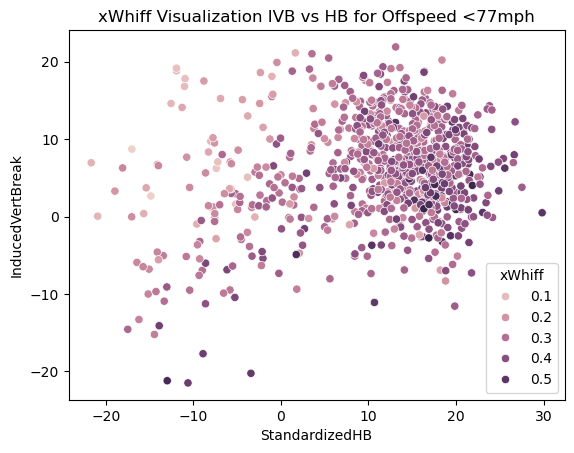

In [78]:
X_test['xWhiff'] = x_whiff_test_OS
sns.scatterplot(x = X_test[(X_test['RelSpeed'] < 77)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] < 77)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] < 77)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Offspeed <77mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Offspeed 77-80mph')]

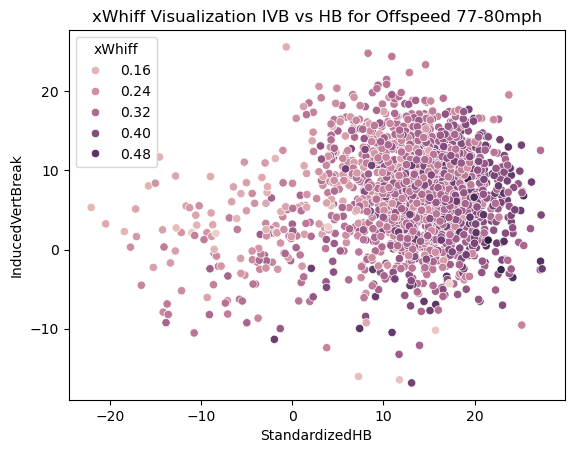

In [80]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 77) & (X_test['RelSpeed'] < 80)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 77) & (X_test['RelSpeed'] < 80)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 77) & (X_test['RelSpeed'] < 80)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Offspeed 77-80mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Offspeed 80-83mph')]

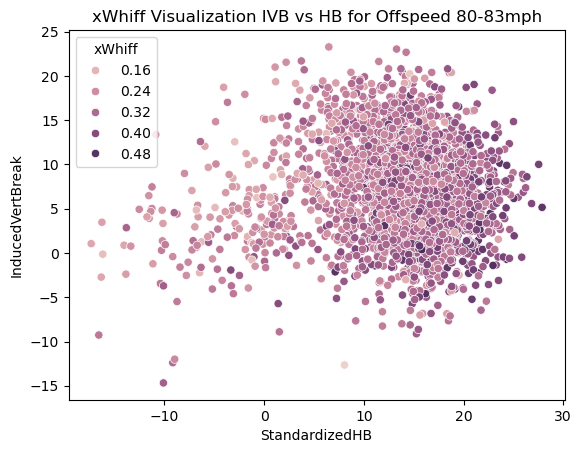

In [81]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 83)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 83)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 83)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Offspeed 80-83mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Offspeed 83-86mph')]

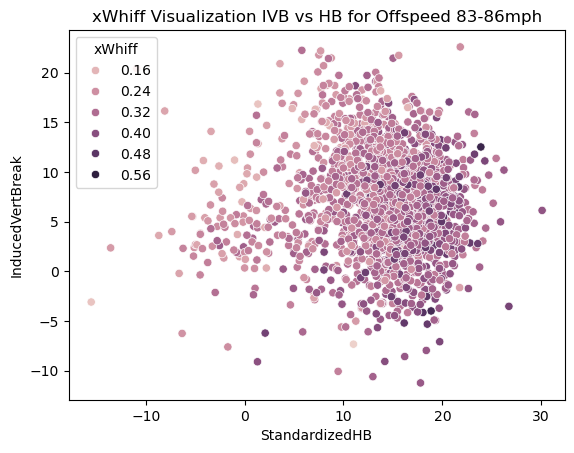

In [83]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 83) & (X_test['RelSpeed'] < 86)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 83) & (X_test['RelSpeed'] < 86)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 83) & (X_test['RelSpeed'] < 86)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Offspeed 83-86mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Offspeed >86mph')]

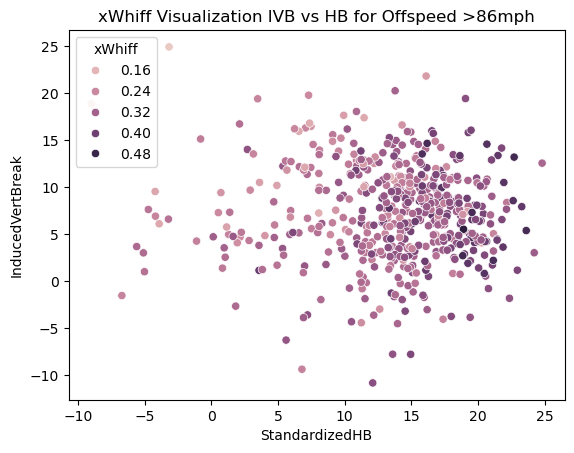

In [86]:
sns.scatterplot(x = X_test[X_test['RelSpeed'] > 86]['StandardizedHB'], y = X_test[X_test['RelSpeed'] > 86]['InducedVertBreak'], hue = X_test[X_test['RelSpeed'] > 86]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Offspeed >86mph')

The interpretation of these scatterplots for the Offspeed section is a bit murkier. It does seem to favor arm side HB and slower pitches, which makes semse, but the addition of the VeloDiff, IVBDiff, and HBDiff features I believe has a big effect. From my knowledge of baseball, those really make a difference when it comes to changeups and splitters. As a pitcher, it is much more important to have a changeup that differs from your fastball rather than it being purely a nasty pitch. Let's see if we can visualize the effect of those three features on the model better.

It is also relevant to note that the outlier pitches away from the main cloud are likely mistagged pitches

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed <3mph Velo Diff')]

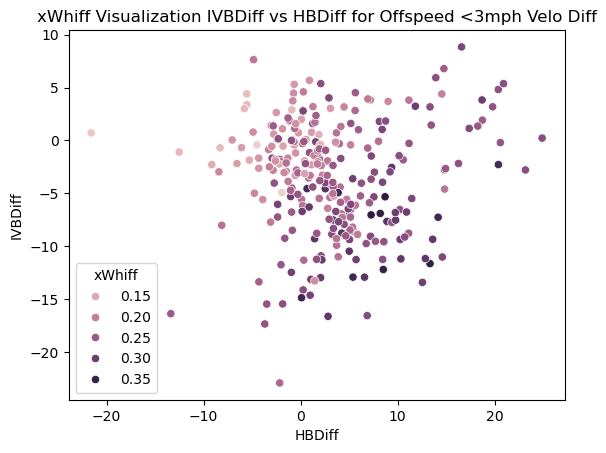

In [88]:
sns.scatterplot(x = X_test[X_test['VeloDiff'] > -3]['HBDiff'], y = X_test[X_test['VeloDiff'] > -3]['IVBDiff'], hue = X_test[X_test['VeloDiff'] > -3]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed <3mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 3-6mph Velo Diff')]

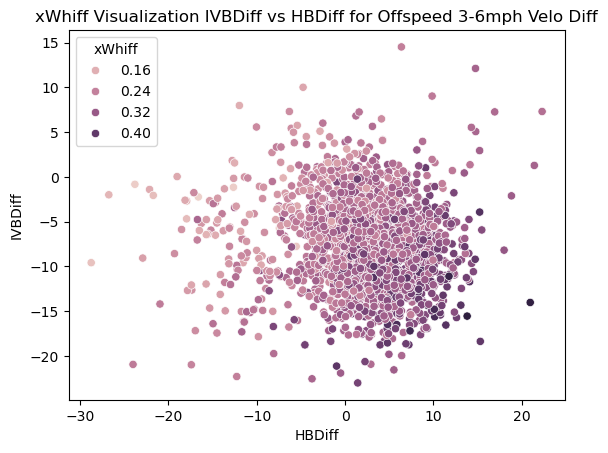

In [90]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] < -3) & (X_test['VeloDiff'] > -6)]['HBDiff'], y = X_test[(X_test['VeloDiff'] < -3) & (X_test['VeloDiff'] > -6)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] < -3) & (X_test['VeloDiff'] > -6)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 3-6mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 6-9mph Velo Diff')]

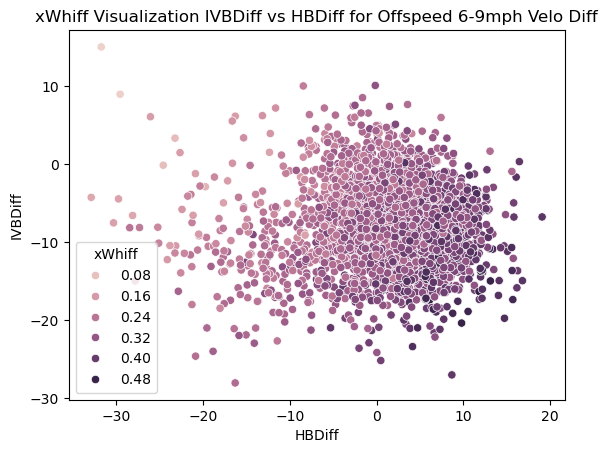

In [92]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] < -6) & (X_test['VeloDiff'] > -9)]['HBDiff'], y = X_test[(X_test['VeloDiff'] < -6) & (X_test['VeloDiff'] > -9)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] < -6) & (X_test['VeloDiff'] > -9)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 6-9mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 9-12mph Velo Diff')]

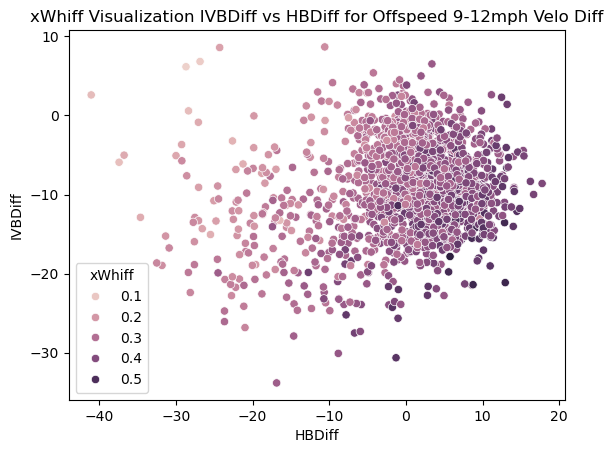

In [94]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] < -9) & (X_test['VeloDiff'] > -12)]['HBDiff'], y = X_test[(X_test['VeloDiff'] < -9) & (X_test['VeloDiff'] > -12)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] < -9) & (X_test['VeloDiff'] > -12)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 9-12mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed >12mph Velo Diff')]

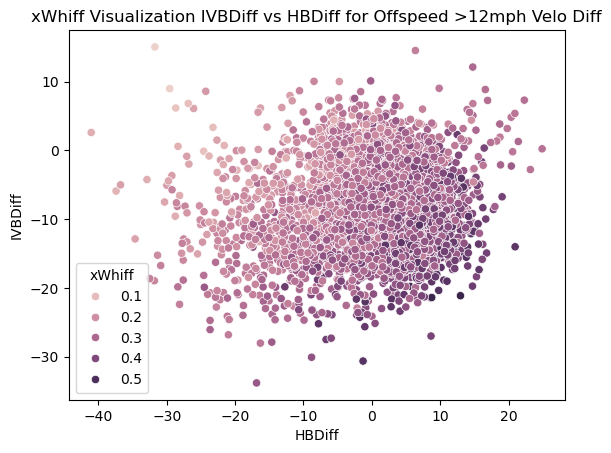

In [96]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] > -12)]['HBDiff'], y = X_test[(X_test['VeloDiff'] > -12)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] > -12)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed >12mph Velo Diff')

These plots show a similar trend to the previous ones, but more clearly. The model favors more arm side movement and greater velocity separation for offspeed pitches

# Model 2: Random Forest

In order to capture more intricacies in the model, I will turn to a Random Forest Classifier. Random Forest is a powerful ML algorithm that uses decision trees and boosting to make classifications and return probabilities, exactly what I need for Stuff+. The tree based model will determine the features most important to the prediction and allow for them to be used multiple times in a tree to capture finer details about the features than logistic regression.

For the initial model, I will start with the default number of trees, 100, and choose the max depth to be 8, in order to visualize the effectiveness of the random forest model before tuning these hyperparameters in a later step.

In [99]:
from sklearn.ensemble import RandomForestClassifier

In [101]:
swings = all_pitches_FB[(all_pitches_FB['PitchCall'] == 'FoulBall') | (all_pitches_FB['PitchCall'] == 'FoulBallNotFieldable') | (all_pitches_FB['PitchCall'] == 'FoulBallFieldable') | (all_pitches_FB['PitchCall'] == 'FouldBallNotFieldable') | (all_pitches_FB['PitchCall'] == 'StrkeSwinging') | (all_pitches_FB['PitchCall'] == 'InPlay') | (all_pitches_FB['PitchCall'] == 'StrikeSwinging')][['PitchCall', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA']].dropna()
swings['PitchCall'] = swings['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)

X_train, X_test, y_train, y_test = train_test_split(swings.drop(columns = 'PitchCall'), swings['PitchCall'], test_size=0.1, random_state=42)

init_model_rand_forest_FB = RandomForestClassifier(n_estimators = 100, max_depth=8, max_features = 'sqrt', random_state=0)
init_model_rand_forest_FB.fit(X_train, y_train)
results_rf_FB = init_model_rand_forest_FB.predict_proba(X_train)
results_rf_FB

array([[0.86520167, 0.13479833],
       [0.86637968, 0.13362032],
       [0.86070201, 0.13929799],
       ...,
       [0.85446155, 0.14553845],
       [0.70061792, 0.29938208],
       [0.7716099 , 0.2283901 ]])

In [102]:
x_whiff_rf_FB_train = [x[1] for x in results_rf_FB]
avg_x_whiff_rf_FB_train = np.mean(x_whiff_rf_FB_train)
actual_whiff_pct_train_rf_FB = y_train.mean()
avg_x_whiff_rf_FB_train, actual_whiff_pct_train_rf_FB

(0.1845164707936013, 0.18456675455417065)

In [103]:
results_rf_FB_test = init_model_rand_forest_FB.predict_proba(X_test)
x_whiff_rf_FB_test = [x[1] for x in results_rf_FB_test]

train_log_loss_rf_FB = metrics.log_loss(y_train, x_whiff_rf_FB_train)
test_log_loss_rf_FB = metrics.log_loss(y_test, x_whiff_rf_FB_test)
train_log_loss_rf_FB, test_log_loss_rf_FB

(0.4611294661994198, 0.4614469421541697)

The log loss is slightly lower than Logistic Regression, which is a positive step. I will tune the model further, but for now, let's visualize the results with IVB vs HB again.

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 88-90mph')]

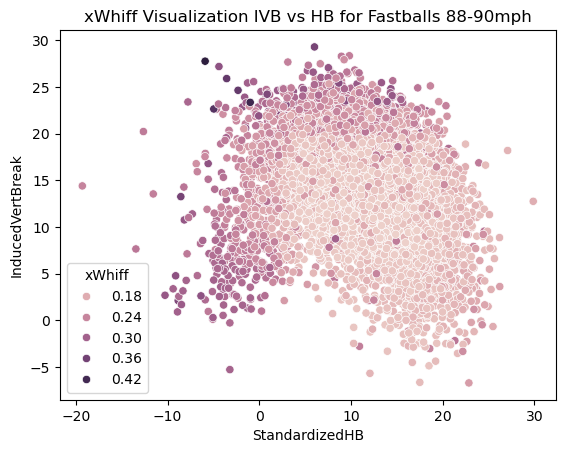

In [107]:
X_test['xWhiff'] = x_whiff_rf_FB_test
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 88-90mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 92-95mph')]

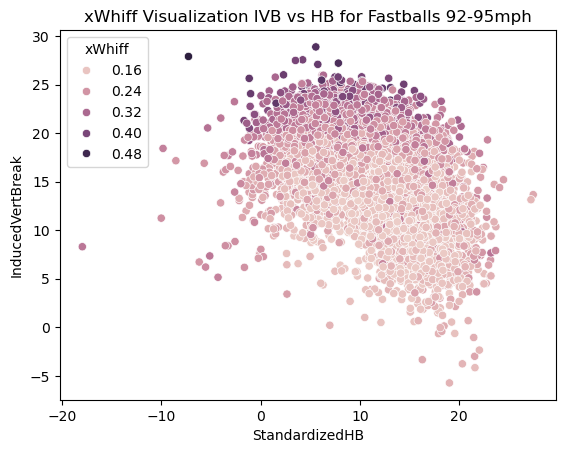

In [108]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 92-95mph')

These look really good! Not only is the log loss lower, but the model seems to be making clearer predictions. There is a clear difference in xWhiff for ride fastballs (more IVB) in both plots and Cutters (HB~0) in the 88-90 plot. The logistic regression model was able to find favorable traits, but it was much more random in its predictions than the random forest. Next, I will tune the model to find the optimal number of trees and tree depth based on log loss.

In [121]:
X_test = X_test.drop(columns = ['xWhiff'])

# define validation set for hyperparameter tuning
_, X_valid, _, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [123]:
for n in np.arange(25, 126, 25):
    for d in np.arange(5, 16, 1):
        model_rand_forest_FB = RandomForestClassifier(n_estimators = n, max_depth=d, max_features = 'sqrt', random_state=0)
        model_rand_forest_FB.fit(X_valid, y_valid)
        results_rf_FB = model_rand_forest_FB.predict_proba(X_valid)
        x_whiff_rf_FB_train = [x[1] for x in results_rf_FB]
        results_rf_FB_test = model_rand_forest_FB.predict_proba(X_test)
        x_whiff_rf_FB_test = [x[1] for x in results_rf_FB_test]
        train_log_loss_rf_FB = metrics.log_loss(y_valid, x_whiff_rf_FB_train)
        test_log_loss_rf_FB = metrics.log_loss(y_test, x_whiff_rf_FB_test)
        print(str(n) + " Trees, Depth: " + str(d) + " - Train loss: " + str(train_log_loss_rf_FB) + " Test loss: " + str(test_log_loss_rf_FB))

25 Trees, Depth: 5 - Train loss: 0.466929678184848 Test loss: 0.46433693237042134
25 Trees, Depth: 6 - Train loss: 0.46398157793872696 Test loss: 0.463170354802413
25 Trees, Depth: 7 - Train loss: 0.4598635462339889 Test loss: 0.4625590981274851
25 Trees, Depth: 8 - Train loss: 0.4548112424355425 Test loss: 0.4624856635017291
25 Trees, Depth: 9 - Train loss: 0.44761061406053765 Test loss: 0.4614027272117269
25 Trees, Depth: 10 - Train loss: 0.4385715344400838 Test loss: 0.4617571528613289
25 Trees, Depth: 11 - Train loss: 0.4271232411557511 Test loss: 0.4619833233313162
25 Trees, Depth: 12 - Train loss: 0.41328833706297463 Test loss: 0.461723431953091
25 Trees, Depth: 13 - Train loss: 0.39997457257507285 Test loss: 0.46227874351068393
25 Trees, Depth: 14 - Train loss: 0.38162042990635026 Test loss: 0.46368955825145425
25 Trees, Depth: 15 - Train loss: 0.36268710599793796 Test loss: 0.46441028726112443
50 Trees, Depth: 5 - Train loss: 0.46688194516589687 Test loss: 0.4642442751249222
50

Based on the hyperparameter tuning above, I will make my random forest model with 25 trees and depth 7. The number of trees turned out to not matter much, while the depth of the trees did. Around 7 depth was where overfitting began. Also, since the amount of trees doesn't adjust loss much, I will choose the lower amount to make the model simpler and less computationally expensive.

In [126]:
model_rand_forest_FB_v1 = RandomForestClassifier(n_estimators = 25, max_depth=7, max_features = 'sqrt', random_state=0)
model_rand_forest_FB_v1.fit(X_train, y_train)
results_rf_FB = model_rand_forest_FB_v1.predict_proba(X_train)
x_whiff_rf_FB_train = [x[1] for x in results_rf_FB]
results_rf_FB_test = model_rand_forest_FB_v1.predict_proba(X_test)
x_whiff_rf_FB_test = [x[1] for x in results_rf_FB_test]

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 88-90mph')]

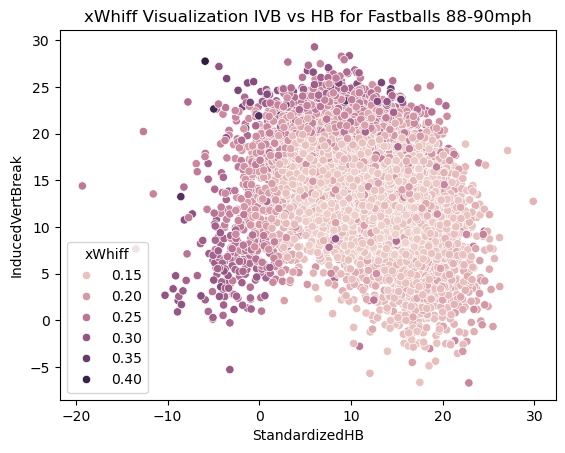

In [128]:
X_test['xWhiff'] = x_whiff_rf_FB_test
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 88-90mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 90-92mph')]

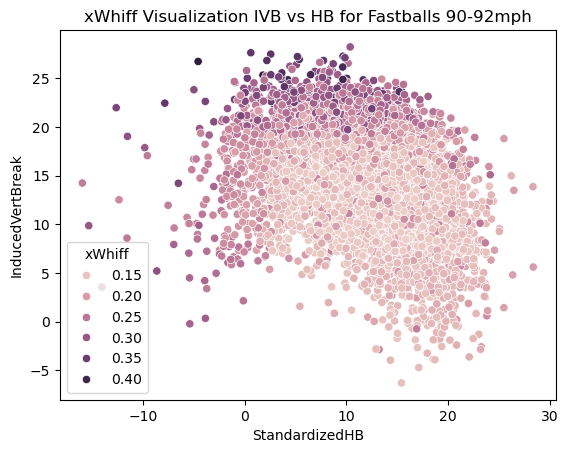

In [130]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 90) & (X_test['RelSpeed'] < 92)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 90) & (X_test['RelSpeed'] < 92)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 90) & (X_test['RelSpeed'] < 92)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 90-92mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 92-95mph')]

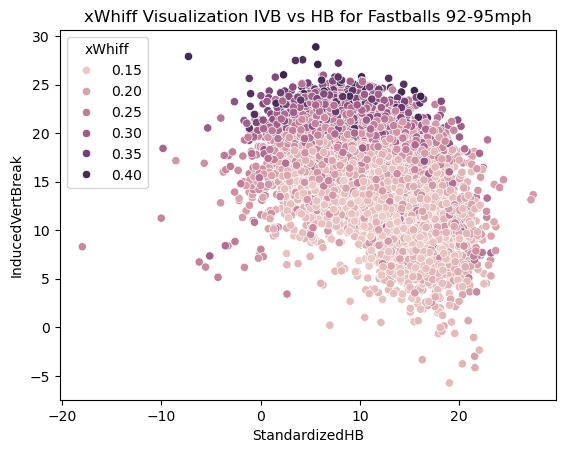

In [132]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 92-95mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs >95mph')]

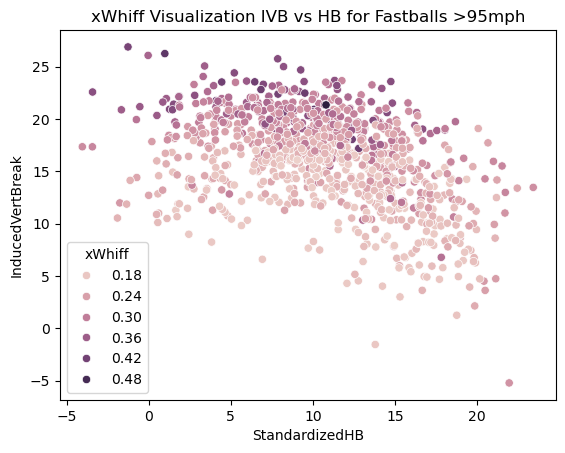

In [134]:
sns.scatterplot(x = X_test[X_test['RelSpeed'] > 95]['StandardizedHB'], y = X_test[X_test['RelSpeed'] > 95]['InducedVertBreak'], hue = X_test[X_test['RelSpeed'] > 95]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs >95mph')

Looks good! Now I will convert xWhiff to Stuff+ and add it to a table containing each pitcher's average for all the features. Stuff+ is simply xWhiff on a scale where 100 is the average and each additional "point" above or below 100 corresponds to 1% above or below the mean. So a Stuff+ of 125 is xWhiff 25% above average, 80 is 20% below average.

In [136]:
takes = all_pitches_FB[(all_pitches_FB['PitchCall'] == 'BallCalled') | (all_pitches_FB['PitchCall'] == 'StrikeCalled') | (all_pitches_FB['PitchCall'] == 'BallinDirt') | (all_pitches_FB['PitchCall'] == 'HitByPitch') | (all_pitches_FB['PitchCall'] == 'BallIntentional')][['RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA']].dropna()
results_rf_fb_takes = model_rand_forest_FB_v1.predict_proba(takes)
x_whiff_rf_fb_takes = [x[1] for x in results_rf_fb_takes]
takes['xWhiff'] = x_whiff_rf_fb_takes
X_train['xWhiff'] = x_whiff_rf_FB_train

all_xWhiff = pd.concat([takes['xWhiff'], X_train['xWhiff'], X_test['xWhiff']])
all_pitches_FB = all_pitches_FB.merge(all_xWhiff, left_index = True, right_index = True)

all_pitches_FB['Stuff+'] = (all_pitches_FB['xWhiff'] / all_pitches_FB['xWhiff'].mean()) * 100

In [137]:
stuff_plus_leaderboard_FB = all_pitches_FB.groupby(['Pitcher', 'TaggedPitchType'])[['Stuff+', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'AdjustedVAA', 'AdjustedHAA']].mean().sort_values('Stuff+', ascending = False)
stuff_plus_leaderboard_FB['Stuff+'] = stuff_plus_leaderboard_FB['Stuff+'].astype(int)
stuff_plus_leaderboard_FB[:10]

Stuff+   RelSpeed  RelHeight   RelSide  \
Pitcher            TaggedPitchType                                           
Adelmann, Jonathan Sinker              200  81.454320   6.364020  2.509930   
Davidson, Zach     Cutter              199  90.952500   6.078520 -0.654650   
Mueller, Matthew   Cutter              194  89.545700   6.468305 -0.474215   
Dean, Tyler        Cutter              192  91.973890   6.132200  1.515820   
Murray, Justin     Cutter              191  79.468980   6.769290 -3.388460   
Heyne, Kyler       Cutter              189  79.461500   5.165770  2.604070   
Jones, Jake        Cutter              183  90.110060   6.092937  0.012337   
Grotyohann, Connor Sinker              181  93.194410   6.216450  1.839100   
Chestnutt, Ben     Sinker              181  73.002990   5.128780  2.833510   
Jameson, Fisher    Cutter              180  84.210264   6.970469  0.662124   

                                    Extension  InducedVertBreak  HorzBreak  \
Pitcher            TaggedPitchType                                           
Adelmann, Jonathan Sinker            5.803620          3.602210 -15.116620   
Davidson, Zach     Cutter            5.764520         23.058200  -1.368940   
Mueller, Matthew   Cutter            6.642875         25.395310 -11.759120   
Dean, Tyler        Cutter            6.278610         21.342650  -0.597050   
Murray, Justin     Cutter            4.954430        -13.785680  -6.876180   
Heyne, Kyler       Cutter            5.681100          6.456930 -14.780800   
Jones, Jake        Cutter            5.846917         23.336863  -1.871747   
Grotyohann, Connor Sinker            6.309180         23.601980   9.118390   
Chestnutt, Ben     Sinker            5.706940         -6.280080 -16.980250   
Jameson, Fisher    Cutter            4.811202          4.278415   1.584423   

                                    AdjustedVAA  AdjustedHAA  
Pitcher            TaggedPitchType                            
Adelmann, Jonathan Sinker             -2.092437    -3.566356  
Davidson, Zach     Cutter              1.323992    -1.558109  
Mueller, Matthew   Cutter              1.231809    -2.892036  
Dean, Tyler        Cutter              1.302040     0.362891  
Murray, Justin     Cutter             -3.625518     4.736334  
Heyne, Kyler       Cutter              0.393660    -2.250230  
Jones, Jake        Cutter              1.440819     1.859017  
Grotyohann, Connor Sinker              0.835897    -0.770015  
Chestnutt, Ben     Sinker             -2.617521    -3.914274  
Jameson, Fisher    Cutter             -1.458420     1.499504

In [140]:
all_pitches_FB = all_pitches_FB.drop(columns = ['xWhiff', 'Stuff+'])

After I first found the Stuff+ Leaderboard for the random forest model, I noticed that the model very much favors cutters. Most of the top cutters seemed to be closer to sliders or misreads/mistags. Since breaking balls naturally have a higher whiff rate than fastballs (32% to 18%, see logistic regression models), cutters that act more like sliders will naturally produce more whiff characterstics, and cause an unfair comparison when compared to fastballs. However, lots of pitchers throw cutters as their primary fastball that don't act similarly to sliders. So, for my final model, I came up with an idea: I'll move cutters to breaking ball model for pitchers whose primary FB is not a cutter, keep in FB model for those who it is their primary fastball.

I will also remove Knuckleballs from the Offspeed model. From inspecting the data, it seems as if not all the Knuckleballs are actually knuckleballs. Some were either mistagged or the tag was used as a placeholder for a misread. Knuckleball Stuff+ can be calculated using the Offspeed Model, I just won't be using any for training

In [234]:
all_pitches_FB = all_pitches[(all_pitches['TaggedPitchType'] == 'Fastball') | (all_pitches['TaggedPitchType'] == 'Sinker') | ((all_pitches['TaggedPitchType'] == 'Cutter') & (all_pitches['primaryFB'] == 'Cutter'))]
all_pitches_BB = all_pitches[(all_pitches['TaggedPitchType'] == 'Curveball') | (all_pitches['TaggedPitchType'] == 'Slider') | ((all_pitches['TaggedPitchType'] == 'Cutter') & (all_pitches['primaryFB'] != 'Cutter'))]
all_pitches_OS = all_pitches[(all_pitches['TaggedPitchType'] == 'ChangeUp') | (all_pitches['TaggedPitchType'] == 'Splitter')]

all_pitches_BB['VeloDiff'] = all_pitches_BB['RelSpeed'] - all_pitches_BB['RelSpeedFBavg']
all_pitches_BB['IVBDiff'] = all_pitches_BB['InducedVertBreak'] - all_pitches_BB['InducedVertBreakFBavg']
all_pitches_BB['HBDiff'] = all_pitches_BB['StandardizedHB'] - all_pitches_BB['StandardizedHBFBavg']

all_pitches_OS['VeloDiff'] = all_pitches_OS['RelSpeed'] - all_pitches_OS['RelSpeedFBavg']
all_pitches_OS['IVBDiff'] = all_pitches_OS['InducedVertBreak'] - all_pitches_OS['InducedVertBreakFBavg']
all_pitches_OS['HBDiff'] = all_pitches_OS['StandardizedHB'] - all_pitches_OS['StandardizedHBFBavg']

C:\Users\mdalq\AppData\Local\Temp\ipykernel_23616\1195192432.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_pitches_BB['VeloDiff'] = all_pitches_BB['RelSpeed'] - all_pitches_BB['RelSpeedFBavg']
C:\Users\mdalq\AppData\Local\Temp\ipykernel_23616\1195192432.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_pitches_BB['IVBDiff'] = all_pitches_BB['InducedVertBreak'] - all_pitches_BB['InducedVertBreakFBavg']
C:\Users\mdalq\AppData\Local\Temp\ipykernel_23616\1195192432.py:7: SettingWithCopyWarning: 

# Final Model: Fastballs

In [236]:
swings = all_pitches_FB[(all_pitches_FB['PitchCall'] == 'FoulBall') | (all_pitches_FB['PitchCall'] == 'FoulBallNotFieldable') | (all_pitches_FB['PitchCall'] == 'FoulBallFieldable') | (all_pitches_FB['PitchCall'] == 'FouldBallNotFieldable') | (all_pitches_FB['PitchCall'] == 'StrkeSwinging') | (all_pitches_FB['PitchCall'] == 'InPlay') | (all_pitches_FB['PitchCall'] == 'StrikeSwinging')][['PitchCall', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA']].dropna()
swings['PitchCall'] = swings['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)

X_train, X_test, y_train, y_test = train_test_split(swings.drop(columns = 'PitchCall'), swings['PitchCall'], test_size=0.1, random_state=42)

model_rand_forest_FB_v2 = RandomForestClassifier(n_estimators=25, max_depth=7, max_features = 'sqrt', random_state=0)
model_rand_forest_FB_v2.fit(X_train, y_train)
results_rf_FB = model_rand_forest_FB_v2.predict_proba(X_train)
x_whiff_rf_FB_train = [x[1] for x in results_rf_FB]
results_rf_FB_test = model_rand_forest_FB_v2.predict_proba(X_test)
x_whiff_rf_FB_test = [x[1] for x in results_rf_FB_test]

In [237]:
takes = all_pitches_FB[(all_pitches_FB['PitchCall'] == 'BallCalled') | (all_pitches_FB['PitchCall'] == 'StrikeCalled') | (all_pitches_FB['PitchCall'] == 'BallinDirt') | (all_pitches_FB['PitchCall'] == 'HitByPitch') | (all_pitches_FB['PitchCall'] == 'BallIntentional')][['RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA']].dropna()
results_rf_fb_takes = model_rand_forest_FB_v2.predict_proba(takes)
x_whiff_rf_fb_takes = [x[1] for x in results_rf_fb_takes]
takes['xWhiff'] = x_whiff_rf_fb_takes
X_train['xWhiff'] = x_whiff_rf_FB_train
X_test['xWhiff'] = x_whiff_rf_FB_test

all_xWhiff = pd.concat([takes['xWhiff'], X_train['xWhiff'], X_test['xWhiff']])
all_pitches_FB = all_pitches_FB.merge(all_xWhiff, left_index = True, right_index = True)

all_pitches_FB['Stuff+'] = (all_pitches_FB['xWhiff'] / all_pitches_FB['xWhiff'].mean()) * 100

In [238]:
stuff_plus_leaderboard_FB = all_pitches_FB.groupby(['Pitcher', 'PitcherTeam', 'TaggedPitchType'])[['Stuff+', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'AdjustedVAA', 'AdjustedHAA']].mean().sort_values('Stuff+', ascending = False)
stuff_plus_leaderboard_FB['Stuff+'] = stuff_plus_leaderboard_FB['Stuff+'].astype(int)
stuff_plus_leaderboard_FB.to_csv('stuff_plus_fb.csv')
stuff_plus_leaderboard_FB[:10]

Stuff+   RelSpeed  RelHeight  \
Pitcher            PitcherTeam TaggedPitchType                                 
Chillot, Gavin     PIT_UNI     Fastball            210  92.437030   5.162390   
Grotyohann, Connor RHO_RAM     Sinker              198  93.194410   6.216450   
Kuhle, Max         JMU_DUK     Sinker              187  90.939340   4.646000   
LaCour, Andrew     CAL_AGO     Sinker              186  79.480990   6.231510   
Anderson, Kade     LSU_TIG     Sinker              181  94.174120   5.621450   
Burns, Chase       WAK_DEA     Sinker              180  97.366990   6.373740   
Nelson, Cameron    WAK_DEA     Sinker              179  92.481590   4.459603   
Smith, Hagen       ARK_RAZ     Sinker              178  95.798738   5.478542   
Stewart, Bradley   EKU_COL     Sinker              177  96.608713   4.488958   
Furtado, Josh      MOR_EAG     Sinker              175  89.796336   5.300440   

                                                 RelSide  Extension  \
Pitcher            PitcherTeam TaggedPitchType                        
Chillot, Gavin     PIT_UNI     Fastball         2.101065   5.531395   
Grotyohann, Connor RHO_RAM     Sinker           1.839100   6.309180   
Kuhle, Max         JMU_DUK     Sinker           1.874190   6.746410   
LaCour, Andrew     CAL_AGO     Sinker          -2.224890   4.682760   
Anderson, Kade     LSU_TIG     Sinker          -0.886680   6.659100   
Burns, Chase       WAK_DEA     Sinker           1.272620   6.893670   
Nelson, Cameron    WAK_DEA     Sinker          -3.361413   6.276827   
Smith, Hagen       ARK_RAZ     Sinker          -3.364411   6.202086   
Stewart, Bradley   EKU_COL     Sinker          -1.344683   5.919269   
Furtado, Josh      MOR_EAG     Sinker           2.476942   5.734833   

                                                InducedVertBreak  HorzBreak  \
Pitcher            PitcherTeam TaggedPitchType                                
Chillot, Gavin     PIT_UNI     Fastball                22.652375   7.149140   
Grotyohann, Connor RHO_RAM     Sinker                  23.601980   9.118390   
Kuhle, Max         JMU_DUK     Sinker                   9.548630  11.723120   
LaCour, Andrew     CAL_AGO     Sinker                  -6.637170   8.289450   
Anderson, Kade     LSU_TIG     Sinker                  20.562220  -3.772250   
Burns, Chase       WAK_DEA     Sinker                  19.304890   1.785040   
Nelson, Cameron    WAK_DEA     Sinker                  11.618547 -17.214210   
Smith, Hagen       ARK_RAZ     Sinker                  15.274621 -15.225347   
Stewart, Bradley   EKU_COL     Sinker                  13.768780 -17.975869   
Furtado, Josh      MOR_EAG     Sinker                  23.532005   9.845911   

                                                AdjustedVAA  AdjustedHAA  
Pitcher            PitcherTeam TaggedPitchType                            
Chillot, Gavin     PIT_UNI     Fastball            1.522383    -0.741517  
Grotyohann, Connor RHO_RAM     Sinker              0.835897    -0.770015  
Kuhle, Max         JMU_DUK     Sinker              1.167853    -1.926687  
LaCour, Andrew     CAL_AGO     Sinker             -3.137103     2.411773  
Anderson, Kade     LSU_TIG     Sinker              0.945847    -0.115106  
Burns, Chase       WAK_DEA     Sinker              0.473589    -0.805422  
Nelson, Cameron    WAK_DEA     Sinker              1.531333     1.166450  
Smith, Hagen       ARK_RAZ     Sinker              0.933904     1.278442  
Stewart, Bradley   EKU_COL     Sinker              1.870941    -1.112728  
Furtado, Josh      MOR_EAG     Sinker              1.300852    -0.956946

# Final Model: Breaking Balls

In [239]:
swings = all_pitches_BB[(all_pitches_BB['PitchCall'] == 'FoulBall') | (all_pitches_BB['PitchCall'] == 'FoulBallNotFieldable') | (all_pitches_BB['PitchCall'] == 'FoulBallFieldable') | (all_pitches_BB['PitchCall'] == 'FouldBallNotFieldable') | (all_pitches_BB['PitchCall'] == 'StrkeSwinging') | (all_pitches_BB['PitchCall'] == 'InPlay') | (all_pitches_BB['PitchCall'] == 'StrikeSwinging')][['PitchCall', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA', 'VeloDiff', 'IVBDiff', 'HBDiff']].dropna()
swings['PitchCall'] = swings['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)

X_train, X_test, y_train, y_test = train_test_split(swings.drop(columns = 'PitchCall'), swings['PitchCall'], test_size=0.1, random_state=42)
_, X_valid, _, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [154]:
# Tune hyperparameters
for n in np.arange(25, 101, 25):
    for d in np.arange(5, 10, 1):
        model_rand_forest = RandomForestClassifier(n_estimators = n, max_depth=d, max_features = 'sqrt', random_state=0)
        model_rand_forest.fit(X_valid, y_valid)
        results_rf = model_rand_forest.predict_proba(X_valid)
        x_whiff_rf_train = [x[1] for x in results_rf]
        results_rf_test = model_rand_forest.predict_proba(X_test)
        x_whiff_rf_test = [x[1] for x in results_rf_test]
        train_log_loss_rf = metrics.log_loss(y_valid, x_whiff_rf_train)
        test_log_loss_rf = metrics.log_loss(y_test, x_whiff_rf_test)
        print(str(n) + " Trees, Depth: " + str(d) + " - Train loss: " + str(train_log_loss_rf) + " Test loss: " + str(test_log_loss_rf))

25 Trees, Depth: 5 - Train loss: 0.6103632091882488 Test loss: 0.6171952863295647
25 Trees, Depth: 6 - Train loss: 0.6061782280788974 Test loss: 0.616371434695141
25 Trees, Depth: 7 - Train loss: 0.6001194681074895 Test loss: 0.6157745901327591
25 Trees, Depth: 8 - Train loss: 0.5926430241850943 Test loss: 0.6159630379248074
25 Trees, Depth: 9 - Train loss: 0.5821293480851157 Test loss: 0.6155487409856149
50 Trees, Depth: 5 - Train loss: 0.6103699428881656 Test loss: 0.617214396675117
50 Trees, Depth: 6 - Train loss: 0.6058381738671642 Test loss: 0.6164789251420193
50 Trees, Depth: 7 - Train loss: 0.6001014232905381 Test loss: 0.6157772924041374
50 Trees, Depth: 8 - Train loss: 0.5918665156461221 Test loss: 0.6155169642715417
50 Trees, Depth: 9 - Train loss: 0.5815291324368594 Test loss: 0.6148291939354815
75 Trees, Depth: 5 - Train loss: 0.6103405850033609 Test loss: 0.6172596554489941
75 Trees, Depth: 6 - Train loss: 0.6059157843900473 Test loss: 0.6165615624143604
75 Trees, Depth: 7

Again, not much difference across the number of trees or depth. 25 trees and with depth 7 it is.

In [ ]:
model_rand_forest_BB = RandomForestClassifier(n_estimators = 25, max_depth=7, max_features = 'sqrt', random_state=0)
model_rand_forest_BB.fit(X_train, y_train)
results_rf_BB = model_rand_forest_BB.predict_proba(X_train)
x_whiff_rf_BB_train = [x[1] for x in results_rf_BB]
results_rf_BB_test = model_rand_forest_BB.predict_proba(X_test)
x_whiff_rf_BB_test = [x[1] for x in results_rf_BB_test]

In [ ]:
takes = all_pitches_BB[(all_pitches_BB['PitchCall'] == 'BallCalled') | (all_pitches_BB['PitchCall'] == 'StrikeCalled') | (all_pitches_BB['PitchCall'] == 'BallinDirt') | (all_pitches_BB['PitchCall'] == 'HitByPitch') | (all_pitches_BB['PitchCall'] == 'BallIntentional')][['RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA', 'VeloDiff', 'IVBDiff', 'HBDiff']].dropna()

results_rf_bb_takes = model_rand_forest_BB.predict_proba(takes)
x_whiff_rf_bb_takes = [x[1] for x in results_rf_bb_takes]
takes['xWhiff'] = x_whiff_rf_bb_takes
X_train['xWhiff'] = x_whiff_rf_BB_train
X_test['xWhiff'] = x_whiff_rf_BB_test

all_xWhiff = pd.concat([takes['xWhiff'], X_train['xWhiff'], X_test['xWhiff']])
all_pitches_BB = all_pitches_BB.merge(all_xWhiff, left_index = True, right_index = True)

all_pitches_BB['Stuff+'] = (all_pitches_BB['xWhiff'] / all_pitches_BB['xWhiff'].mean()) * 100

In [ ]:
stuff_plus_leaderboard_BB = all_pitches_BB.groupby(['Pitcher', 'PitcherTeam', 'TaggedPitchType'])[['Stuff+', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'AdjustedVAA', 'AdjustedHAA']].mean().sort_values('Stuff+', ascending = False)
stuff_plus_leaderboard_BB['Stuff+'] = stuff_plus_leaderboard_BB['Stuff+'].astype(int)
stuff_plus_leaderboard_BB.to_csv('stuff_plus_bb.csv')
stuff_plus_leaderboard_BB[:10]

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls <70mph')]

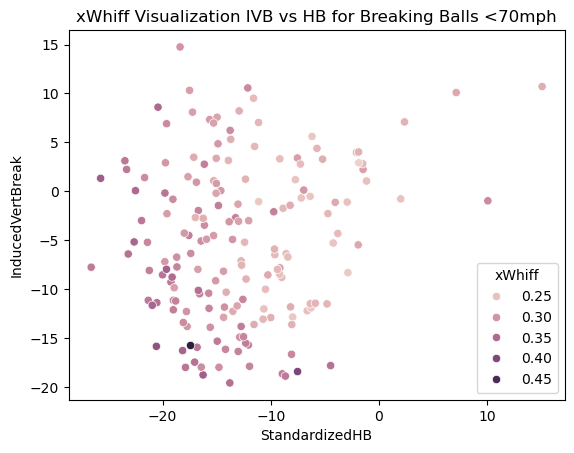

In [193]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] < 70)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] < 70)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] < 70)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls <70mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls 70-75mph')]

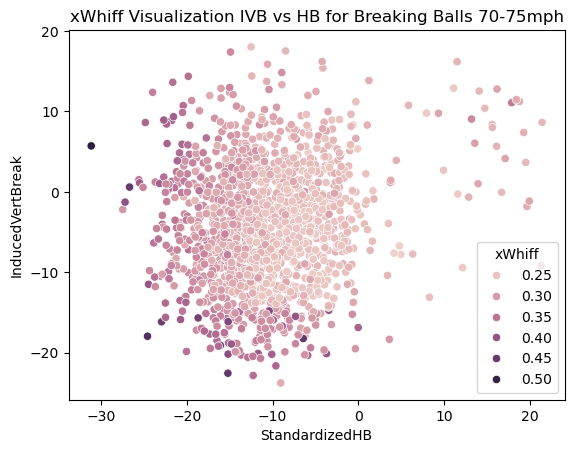

In [194]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 70) & (X_test['RelSpeed'] < 75)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 70) & (X_test['RelSpeed'] < 75)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 70) & (X_test['RelSpeed'] < 75)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls 70-75mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls 75-80mph')]

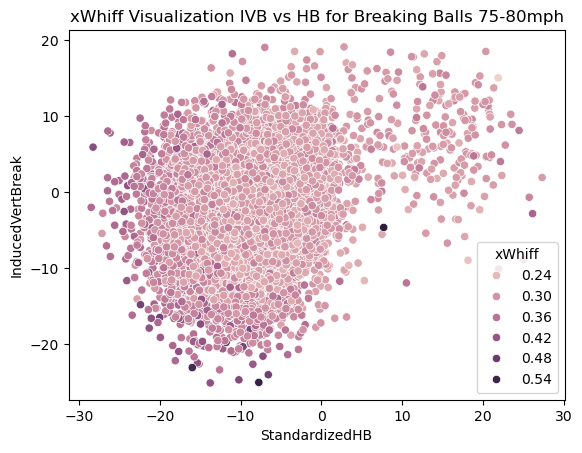

In [196]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 75) & (X_test['RelSpeed'] < 80)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 75) & (X_test['RelSpeed'] < 80)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 75) & (X_test['RelSpeed'] < 80)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls 75-80mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls 80-85mph')]

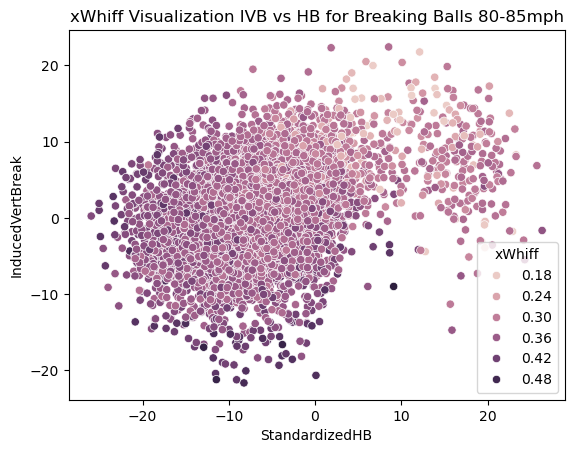

In [198]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 85)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 85)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 85)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls 80-85mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls >85mph')]

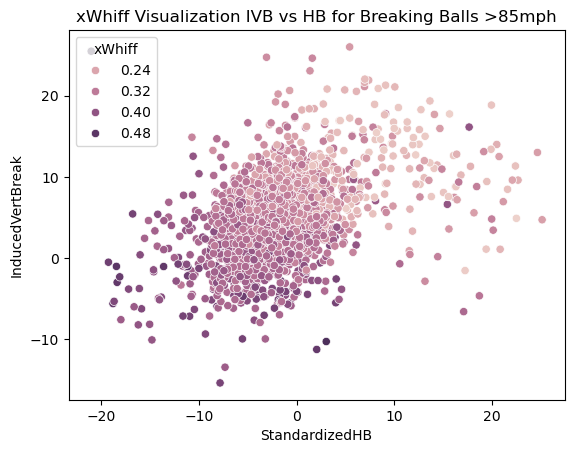

In [199]:
sns.scatterplot(x = X_test[X_test['RelSpeed'] > 85]['StandardizedHB'], y = X_test[X_test['RelSpeed'] > 85]['InducedVertBreak'], hue = X_test[X_test['RelSpeed'] > 85]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls >85mph')

# Final Model: Offspeeds

In [ ]:
swings = all_pitches_OS[(all_pitches_OS['PitchCall'] == 'FoulBall') | (all_pitches_OS['PitchCall'] == 'FoulBallNotFieldable') | (all_pitches_OS['PitchCall'] == 'FoulBallFieldable') | (all_pitches_OS['PitchCall'] == 'FouldBallNotFieldable') | (all_pitches_OS['PitchCall'] == 'StrkeSwinging') | (all_pitches_OS['PitchCall'] == 'InPlay') | (all_pitches_OS['PitchCall'] == 'StrikeSwinging')][['PitchCall', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA', 'VeloDiff', 'IVBDiff', 'HBDiff']].dropna()
swings['PitchCall'] = swings['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)

X_train, X_test, y_train, y_test = train_test_split(swings.drop(columns = 'PitchCall'), swings['PitchCall'], test_size=0.1, random_state=42)
_, X_valid, _, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [205]:
# Tune Hyperparameters
for n in np.arange(25, 101, 25):
    for d in np.arange(5, 10, 1):
        model_rand_forest = RandomForestClassifier(n_estimators = n, max_depth=d, max_features = 'sqrt', random_state=0)
        model_rand_forest.fit(X_valid, y_valid)
        results_rf = model_rand_forest.predict_proba(X_valid)
        x_whiff_rf_train = [x[1] for x in results_rf]
        results_rf_test = model_rand_forest.predict_proba(X_test)
        x_whiff_rf_test = [x[1] for x in results_rf_test]
        train_log_loss_rf = metrics.log_loss(y_valid, x_whiff_rf_train)
        test_log_loss_rf = metrics.log_loss(y_test, x_whiff_rf_test)
        print(str(n) + " Trees, Depth: " + str(d) + " - Train loss: " + str(train_log_loss_rf) + " Test loss: " + str(test_log_loss_rf))

25 Trees, Depth: 5 - Train loss: 0.6028903258817597 Test loss: 0.6186268941592566
25 Trees, Depth: 6 - Train loss: 0.5942191373377415 Test loss: 0.6182346743458412
25 Trees, Depth: 7 - Train loss: 0.5828464366768762 Test loss: 0.6184776991640202
25 Trees, Depth: 8 - Train loss: 0.5665702227311028 Test loss: 0.6188095821723628
25 Trees, Depth: 9 - Train loss: 0.5481806613120623 Test loss: 0.6207865398266872
50 Trees, Depth: 5 - Train loss: 0.602849592948037 Test loss: 0.6192244455927163
50 Trees, Depth: 6 - Train loss: 0.5935620326578321 Test loss: 0.6182382701517071
50 Trees, Depth: 7 - Train loss: 0.5819403147633452 Test loss: 0.6181959826363556
50 Trees, Depth: 8 - Train loss: 0.5655203924961203 Test loss: 0.6184147299634773
50 Trees, Depth: 9 - Train loss: 0.5468357558026675 Test loss: 0.6190778320650074
75 Trees, Depth: 5 - Train loss: 0.6030277175817466 Test loss: 0.6188938300785839
75 Trees, Depth: 6 - Train loss: 0.593742192581265 Test loss: 0.6179232190746261
75 Trees, Depth: 7

The model seems to overfit to the train data a bit more for the offspeed model than the others with more depth, so I will choose 25 trees with depth 5 for this model.

In [ ]:
model_rand_forest_OS = RandomForestClassifier(n_estimators = 25, max_depth=5, max_features = 'sqrt', random_state=0)
model_rand_forest_OS.fit(X_train, y_train)
results_rf_OS = model_rand_forest_OS.predict_proba(X_train)
x_whiff_rf_OS_train = [x[1] for x in results_rf_OS]
results_rf_OS_test = model_rand_forest_OS.predict_proba(X_test)
x_whiff_rf_OS_test = [x[1] for x in results_rf_OS_test]

In [ ]:
takes = all_pitches_OS[(all_pitches_OS['PitchCall'] == 'BallCalled') | (all_pitches_OS['PitchCall'] == 'StrikeCalled') | (all_pitches_OS['PitchCall'] == 'BallinDirt') | (all_pitches_OS['PitchCall'] == 'HitByPitch') | (all_pitches_OS['PitchCall'] == 'BallIntentional')][['RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA', 'VeloDiff', 'IVBDiff', 'HBDiff']].dropna()

results_rf_OS_takes = model_rand_forest_OS.predict_proba(takes)
x_whiff_rf_OS_takes = [x[1] for x in results_rf_OS_takes]
takes['xWhiff'] = x_whiff_rf_OS_takes
X_train['xWhiff'] = x_whiff_rf_OS_train
X_test['xWhiff'] = x_whiff_rf_OS_test

all_xWhiff = pd.concat([takes['xWhiff'], X_train['xWhiff'], X_test['xWhiff']])
all_pitches_OS = all_pitches_OS.merge(all_xWhiff, left_index = True, right_index = True)

all_pitches_OS['Stuff+'] = (all_pitches_OS['xWhiff'] / all_pitches_OS['xWhiff'].mean()) * 100

In [ ]:
stuff_plus_leaderboard_OS = all_pitches_OS.groupby(['Pitcher', 'PitcherTeam', 'TaggedPitchType'])[['Stuff+', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'AdjustedVAA', 'AdjustedHAA']].mean().sort_values('Stuff+', ascending = False)
stuff_plus_leaderboard_OS['Stuff+'] = stuff_plus_leaderboard_OS['Stuff+'].astype(int)
stuff_plus_leaderboard_OS.to_csv('stuff_plus_os.csv')
stuff_plus_leaderboard_OS[:10]

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed <3mph Velo Diff')]

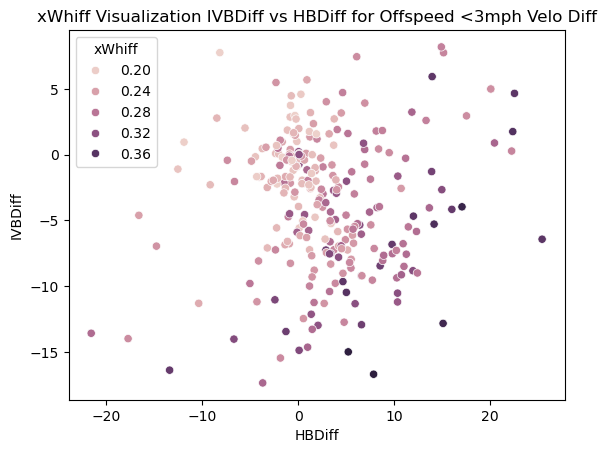

In [214]:
sns.scatterplot(x = X_test[X_test['VeloDiff'] > -3]['HBDiff'], y = X_test[X_test['VeloDiff'] > -3]['IVBDiff'], hue = X_test[X_test['VeloDiff'] > -3]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed <3mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 3-6mph Velo Diff')]

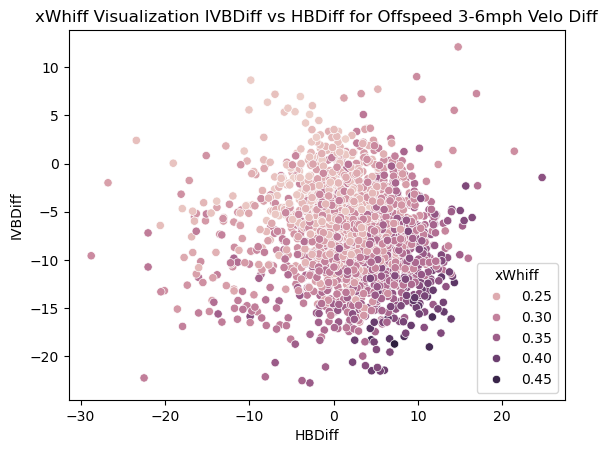

In [215]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] < -3) & (X_test['VeloDiff'] > -6)]['HBDiff'], y = X_test[(X_test['VeloDiff'] < -3) & (X_test['VeloDiff'] > -6)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] < -3) & (X_test['VeloDiff'] > -6)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 3-6mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 6-9mph Velo Diff')]

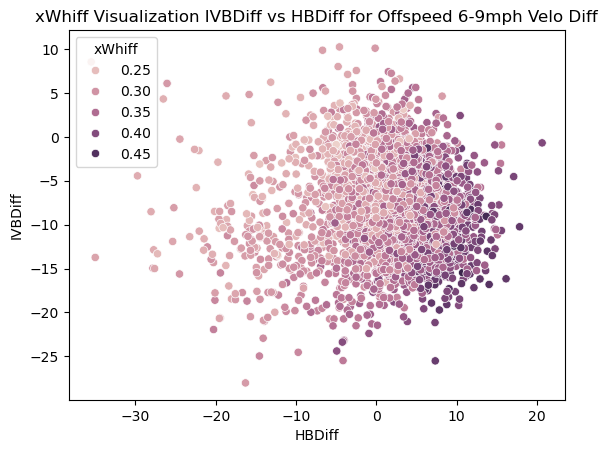

In [218]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] < -6) & (X_test['VeloDiff'] > -9)]['HBDiff'], y = X_test[(X_test['VeloDiff'] < -6) & (X_test['VeloDiff'] > -9)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] < -6) & (X_test['VeloDiff'] > -9)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 6-9mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 9-12mph Velo Diff')]

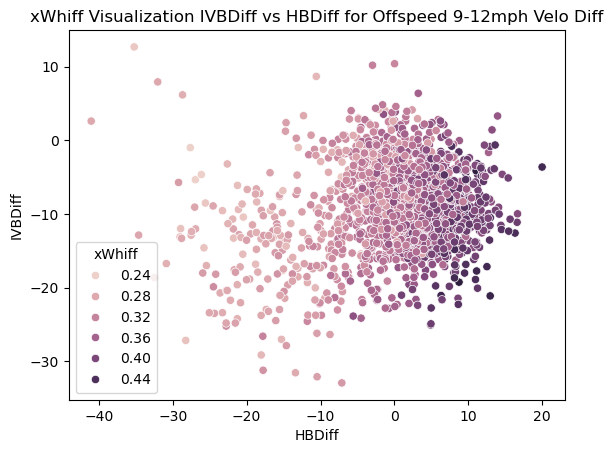

In [220]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] < -9) & (X_test['VeloDiff'] > -12)]['HBDiff'], y = X_test[(X_test['VeloDiff'] < -9) & (X_test['VeloDiff'] > -12)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] < -9) & (X_test['VeloDiff'] > -12)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 9-12mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed >12mph Velo Diff')]

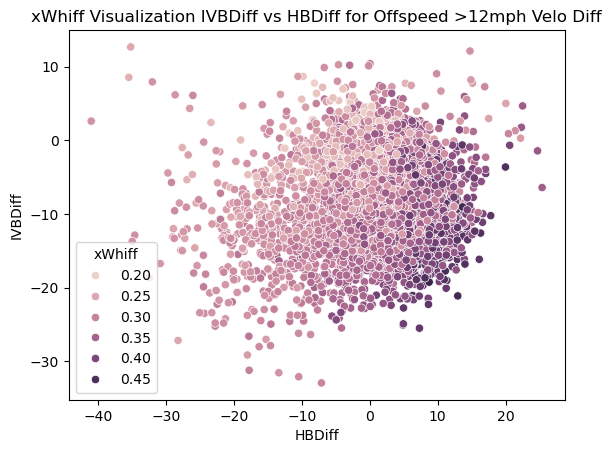

In [222]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] > -12)]['HBDiff'], y = X_test[(X_test['VeloDiff'] > -12)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] > -12)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed >12mph Velo Diff')

All my pitches for fun

In [225]:
pd.concat([stuff_plus_leaderboard_FB.loc['Dalquist, Matthew', 'CSD_TRI'], stuff_plus_leaderboard_BB.loc['Dalquist, Matthew', 'CSD_TRI'], stuff_plus_leaderboard_OS.loc['Dalquist, Matthew', 'CSD_TRI']])

C:\Users\mdalq\AppData\Local\Temp\ipykernel_23616\1629298041.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  pd.concat([stuff_plus_leaderboard_FB.loc['Dalquist, Matthew', 'CSD_TRI'], stuff_plus_leaderboard_BB.loc['Dalquist, Matthew', 'CSD_TRI'], stuff_plus_leaderboard_OS.loc['Dalquist, Matthew', 'CSD_TRI']])


Stuff+   RelSpeed  RelHeight   RelSide  Extension  \
TaggedPitchType                                                      
Fastball            123  89.588989   5.560237  0.998319   5.670494   
Slider              104  82.464386   5.384347  1.104759   5.416370   
Curveball            85  74.393721   5.510369  0.985457   5.152029   
ChangeUp             98  83.498341   5.222934  1.383380   5.518673   

                 InducedVertBreak  HorzBreak  AdjustedVAA  AdjustedHAA  
TaggedPitchType                                                         
Fastball                20.294646  11.418265     0.625838     0.848264  
Slider                   2.789703  -3.509815     0.710165     1.136887  
Curveball              -10.820909 -12.673592    -0.232197     0.211264  
ChangeUp                 8.775456  17.920767     0.703335     0.829509

In [230]:
# export models for use in streamlit app
import joblib

joblib.dump(model_rand_forest_FB_v2, 'FB_model.pkl')
joblib.dump(model_rand_forest_BB, 'BB_model.pkl')
joblib.dump(model_rand_forest_OS, 'OS_model.pkl')

['OS_model.pkl']